In [394]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib.dates import date2num
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.pyplot as plt
import random
sns.set()
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import accuracy_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import itertools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, classification_report
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
import warnings
from keras.optimizers import Adam
warnings.filterwarnings("ignore")
np.random.seed(1)
from calendar import monthrange
from sklearn.metrics import mean_absolute_error, mean_squared_error
import random
import tensorflow as tf

# Importante

Para las redes neuronales estamos usandos Keras, el cual requiere de tensorflow en el back para poder usarse. Antes de correr ciertos algoritmos se deberá tener configurado el entorno.


pip install keras

pip install tensorflow

pip install pmdarima



Primero leemos los dataset por separado. Luego iremos formando diferentes dataset dependiendo del uso que necesitemos. En este caso los dataset inciales son oficiales por lo que se les ha realizado un pequeño preprocesado, es por ello que no se realiza la busqueda de null, ceros u otros valores que afecten al dataset.

Los dataset iniciales son de la demanda y la producción en bruto de la energía en Iraq por países. Para este proyecto se hará de la totalidad del país, es decir la suma de todos los piases y se analizarán como una serie de tiempo

In [203]:
datosDemandaBruto = pd.read_csv("Demand13.csv")
datosProduccionBruto = pd.read_csv("Supply13.csv")

In [204]:
print(datosDemandaBruto)
datosDemandaBruto.head()

       Hours  Baghdad  Nynwa  Kirkuk  Slah El-Din  Anbar  Dyala  Babil  Kerb.  \
0          1     3294   1243     757          488    471    598    525    514   
1          2     2973   1151     753          477    436    570    500    469   
2          3     2758   1105     727          471    419    604    478    430   
3          4     2703   1220     717          470    463    564    497    465   
4          5     2954   1358     751          519    515    626    553    517   
...      ...      ...    ...     ...          ...    ...    ...    ...    ...   
26347     20     4894   1906    1206         1008    912   1112   1112    914   
26348     21     4550   1798    1158          928    862   1047   1027    869   
26349     22     4326   1683    1091          868    818   1001    972    807   
26350     23     4090   1567     988          819    782    935    892    780   
26351     24     3954   1465     942          780    750    879    838    728   

       Najaf  Dywan.  Wasit

,Hours,Baghdad,Nynwa,Kirkuk,Slah El-Din,Anbar,Dyala,Babil,Kerb.,Najaf,Dywan.,Wasit,Muthnna,Thi-Qar,Mesan,Basrah
0,1,3294,1243,757,488,471,598,525,514,474,307,404,208,573,369,1254
1,2,2973,1151,753,477,436,570,500,469,437,284,374,193,536,342,1100
2,3,2758,1105,727,471,419,604,478,430,420,273,359,185,519,328,1056
3,4,2703,1220,717,470,463,564,497,465,451,301,397,204,522,363,1100
4,5,2954,1358,751,519,515,626,553,517,502,335,442,228,574,404,1298


In [205]:
print(datosProduccionBruto)
datosProduccionBruto.head()

       Hours  Bagh.  Nynwa  Kirkuk  Slah El-Din  Anbar  Dyala  Babil  Kerb.  \
0          1   3294    740     668          488    394    598    525    514   
1          2   2973    751     753          477    387    570    500    469   
2          3   2758    760     727          471    374    604    478    430   
3          4   2703    759     717          470    365    546    490    433   
4          5   2794    727     751          470    374    578    539    472   
...      ...    ...    ...     ...          ...    ...    ...    ...    ...   
26347     20   3364    765     762          418    421    587    648    608   
26348     21   3437    748     751          412    418    617    678    638   
26349     22   3368    761     751          420    411    603    719    689   
26350     23   3373    801     782          424    406    614    663    681   
26351     24   3169    853     759          422    404    604    568    593   

       Najaf  Dywan.  Wasit  Muthnna  Thi-Qar  Mesa

,Hours,Bagh.,Nynwa,Kirkuk,Slah El-Din,Anbar,Dyala,Babil,Kerb.,Najaf,Dywan.,Wasit,Muthnna,Thi-Qar,Mesan,Basrah
0,1,3294,740,668,488,394,598,525,514,474,246,397,185,573,294,1104
1,2,2973,751,753,477,387,570,500,469,437,223,362,177,536,269,1030
2,3,2758,760,727,471,374,604,478,430,420,210,347,169,519,229,956
3,4,2703,759,717,470,365,546,490,433,420,202,350,172,522,232,953
4,5,2794,727,751,470,374,578,539,472,449,246,389,191,574,275,1003


Para el total de horas sumaremos el valor de todas las columna, ya que cada columna representa el valor de cada provincia, creando una nueva columna con esto mismo.

In [206]:
datosDemandaTotalHoras = pd.DataFrame()
datosProduccionTotalHoras = pd.DataFrame()

In [207]:
datosDemandaTotalHoras["total"] = datosDemandaBruto.iloc[:, 1:].sum(axis=1)
datosProduccionTotalHoras["total"] = datosProduccionBruto.iloc[:, 1:].sum(axis=1)

In [208]:
datosDemandaTotalHoras["Hours"] = datosDemandaBruto["Hours"]
datosProduccionTotalHoras["Hours"] = datosProduccionBruto["Hours"]

In [209]:
datosDemandaTotalSinHoras = pd.DataFrame()
datosProduccionTotalSinHoras = pd.DataFrame()

In [210]:
datosDemandaTotalSinHoras["total"] = datosDemandaBruto.iloc[:, 1:].sum(axis=1)
datosProduccionTotalSinHoras["total"] = datosProduccionBruto.iloc[:, 1:].sum(axis=1)

In [211]:
datosDemandaTotalHoras.head()


,total,Hours
0,11479,1
1,10595,2
2,10132,3
3,10437,4
4,11576,5


In [212]:
datosDemandaTotalSinHoras.head()

,total
0,11479
1,10595
2,10132
3,10437
4,11576


Ahora partimos de un nuevo dataset el cual tiene una columna con las demanda/produccion por horas, es decir cada fila es una hora y cada 24 filas es un día. Una vez tenemos estos dos dataset, vamos a pasar estas horas a dias para tener los otros dos dataset faltantes.

In [213]:
suma_24_demanda = []
suma_24_produccion = []

In [214]:
for i in range(0, len(datosDemandaTotalSinHoras), 24):
    end = i + 24
    if end > len(datosDemandaTotalSinHoras):
        end = len(datosDemandaTotalSinHoras)
    suma_24_demanda.append(datosDemandaTotalSinHoras[i:end].sum(axis=0).sum())

In [215]:
for i in range(0, len(datosProduccionTotalSinHoras), 24):
    end = i + 24
    if end > len(datosProduccionTotalSinHoras):
        end = len(datosProduccionTotalSinHoras)
    suma_24_produccion.append(datosProduccionTotalSinHoras[i:end].sum(axis=0).sum())

In [216]:
datosDemandaTotalDias = pd.DataFrame({'Total': suma_24_demanda})
datosProduccionTotalDias = pd.DataFrame({'Total': suma_24_produccion})

In [217]:
diasDemanda = pd.date_range(start='2019-01-01', periods=len(suma_24_demanda), freq='D')
diasProduccion = pd.date_range(start='2019-01-01', periods=len(suma_24_produccion), freq='D')

In [218]:
datosDemandaTotalDias["fecha"] = diasDemanda
datosProduccionTotalDias["fecha"] = diasProduccion

Despues de hacer todas estas transformaciones ya tenemos los 4 dataset que queremos: datosDemandaTotalHoras/datosProduccionTotalHoras los cuales tiene la produccion total por ahora y datosDemandaTotalDias/datosProduccionTotalDias los cuales tienen la produccion por dias

In [219]:
datosDemandaTotalHoras.head()


,total,Hours
0,11479,1
1,10595,2
2,10132,3
3,10437,4
4,11576,5


In [220]:
datosProduccionTotalHoras.head()

,total,Hours
0,10494,1
1,9914,2
2,9452,3
3,9334,4
4,9832,5


In [221]:
datosHorariosDemanda = datosDemandaTotalHoras.rename(columns={'total': 'Demanda'})
datosHorariosDemanda

,Demanda,Hours
0,11479,1
1,10595,2
2,10132,3
3,10437,4
4,11576,5
...,...,...
26347,19725,20
26348,18376,21
26349,17323,22
26350,16220,23


In [222]:
datosHorariosProduccion = datosProduccionTotalHoras.rename(columns={'total': 'Produccion'})
datosHorariosProduccion

,Produccion,Hours
0,10494,1
1,9914,2
2,9452,3
3,9334,4
4,9832,5
...,...,...
26347,12754,20
26348,12639,21
26349,12320,22
26350,11802,23


In [223]:
datosHorariosProduccion['Demanda'] = datosHorariosDemanda['Demanda']
datosHorariosProduccion

,Produccion,Hours,Demanda
0,10494,1,11479
1,9914,2,10595
2,9452,3,10132
3,9334,4,10437
4,9832,5,11576
...,...,...,...
26347,12754,20,19725
26348,12639,21,18376
26349,12320,22,17323
26350,11802,23,16220


In [224]:
datosDemandaTotalDias.head()

,Total,fecha
0,379726,2019-01-01
1,383590,2019-01-02
2,378901,2019-01-03
3,378180,2019-01-04
4,385805,2019-01-05


In [225]:
datosProduccionTotalDias.head()

,Total,fecha
0,289005,2019-01-01
1,288843,2019-01-02
2,283581,2019-01-03
3,285621,2019-01-04
4,283991,2019-01-05


In [226]:
data = pd.merge(datosDemandaTotalDias, datosProduccionTotalDias, on='fecha')

In [227]:
data = data.rename(columns={'Total_x': 'Demanda','Total_y': 'Produccion'})

In [228]:
data = data.set_index('fecha')

In [229]:
data = data[data.index < pd.to_datetime("31-12-2021")]

In [230]:
data.info()
data


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2019-01-01 to 2021-12-30
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Demanda     1095 non-null   int64
 1   Produccion  1095 non-null   int64
dtypes: int64(2)
memory usage: 25.7 KB


,Demanda,Produccion
fecha,,
2019-01-01,379726,289005
2019-01-02,383590,288843
2019-01-03,378901,283581
2019-01-04,378180,285621
2019-01-05,385805,283991
...,...,...
2021-12-26,466243,299610
2021-12-27,435243,291977
2021-12-28,420410,279246


# Estudio de estaciones

Después de informarme un poco sobre el país, he cogido las 4 estaciones según los meses para ver si hay alguna relación. De primera intuición podemos imaginar que a ser un país caluroso en verano y fresco en invierno, en estas estaciones deberíamos tener mayor demanda en estos periodos

In [231]:
estaciones = {
    1: 'Invierno',
    2: 'Invierno',
    3: 'Invierno',
    4: 'Primavera',
    5: 'Primavera',
    6: 'Verano',
    7: 'Verano',
    8: 'Verano',
    9: 'Verano',
    10: 'Otoño',
    11: 'Otoño',
    12: 'Invierno'
}

In [232]:
dataEstacion = data.copy()

In [233]:
dataEstacion['estacion'] = data.index.month.map(estaciones)

In [234]:
dataEstacion.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2019-01-01 to 2021-12-30
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Demanda     1095 non-null   int64 
 1   Produccion  1095 non-null   int64 
 2   estacion    1095 non-null   object
dtypes: int64(2), object(1)
memory usage: 34.2+ KB


In [235]:
dataEstacion

,Demanda,Produccion,estacion
fecha,,,
2019-01-01,379726,289005,Invierno
2019-01-02,383590,288843,Invierno
2019-01-03,378901,283581,Invierno
2019-01-04,378180,285621,Invierno
2019-01-05,385805,283991,Invierno
...,...,...,...
2021-12-26,466243,299610,Invierno
2021-12-27,435243,291977,Invierno
2021-12-28,420410,279246,Invierno


In [236]:
dataEstacion2 = dataEstacion.copy()

In [237]:
dataEstacion2.groupby(['estacion'])['Demanda'].mean()

estacion
Invierno     367675.931129
Otoño        342338.863388
Primavera    365714.278689
Verano       540844.855191
Name: Demanda, dtype: float64

In [238]:
dataEstacion2.groupby(['estacion'])['Produccion'].mean()

estacion
Invierno     268132.415978
Otoño        283917.808743
Primavera    306742.420765
Verano       403776.814208
Name: Produccion, dtype: float64

<Axes: xlabel='fecha'>

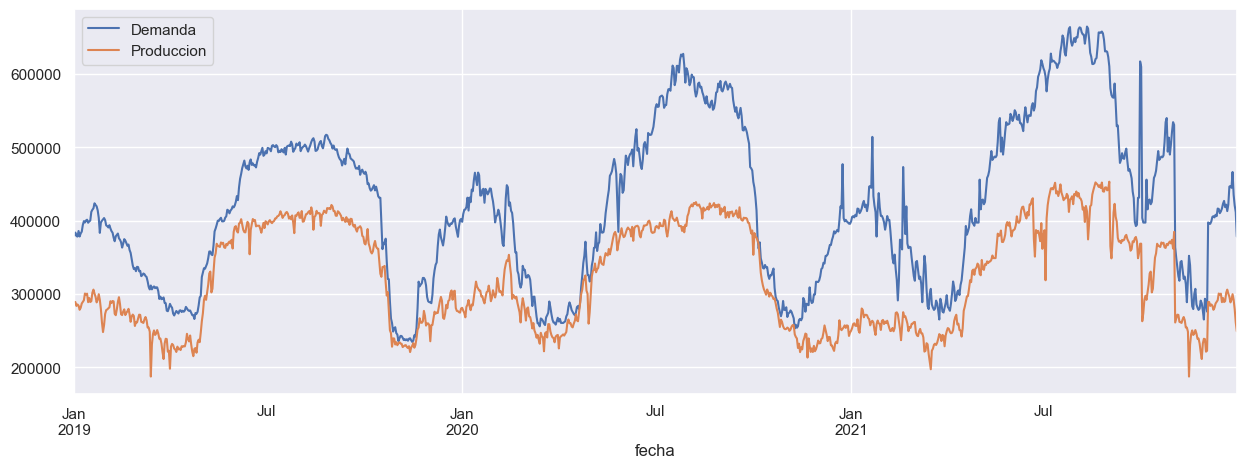

In [239]:
dataEstacion2.plot(figsize=(15,5))

Ahora vamos a entrenar una red LSTM con los años 2019 y 2020 para ver si es capaz de predecir las estaciones en 2021
Para ello con convertiremos las etiquetas de estaciones del año a una forma numérica (codificación one-hot) para que el modelo pueda entenderlas.
Se va a probar con ventanas de 7,30,60,100,180 dias  
Todo esto cogiendo una sola caracteristica luego, la realizaré con las dos para comparar resultados



In [240]:
dataLSTMEstacion = dataEstacion.copy()

In [241]:
#dataLSTMEstacion.to_csv("aa.csv", index=False)

In [242]:
dataLSTMEstacion

,Demanda,Produccion,estacion
fecha,,,
2019-01-01,379726,289005,Invierno
2019-01-02,383590,288843,Invierno
2019-01-03,378901,283581,Invierno
2019-01-04,378180,285621,Invierno
2019-01-05,385805,283991,Invierno
...,...,...,...
2021-12-26,466243,299610,Invierno
2021-12-27,435243,291977,Invierno
2021-12-28,420410,279246,Invierno


# Estudio Covid


In [243]:
dataPreCovid = data[data.index <= pd.to_datetime("23-feb-2020")]
dataPreCovid = dataPreCovid[pd.to_datetime("15-12-2019") <= dataPreCovid.index ]
dataPreCovid

,Demanda,Produccion
fecha,,
2019-12-15,375697,265910
2019-12-16,389443,272995
2019-12-17,405381,285184
2019-12-18,398381,280298
2019-12-19,394335,290496
...,...,...
2020-02-19,375118,296528
2020-02-20,356693,293828
2020-02-21,356625,296104


<Axes: xlabel='fecha'>

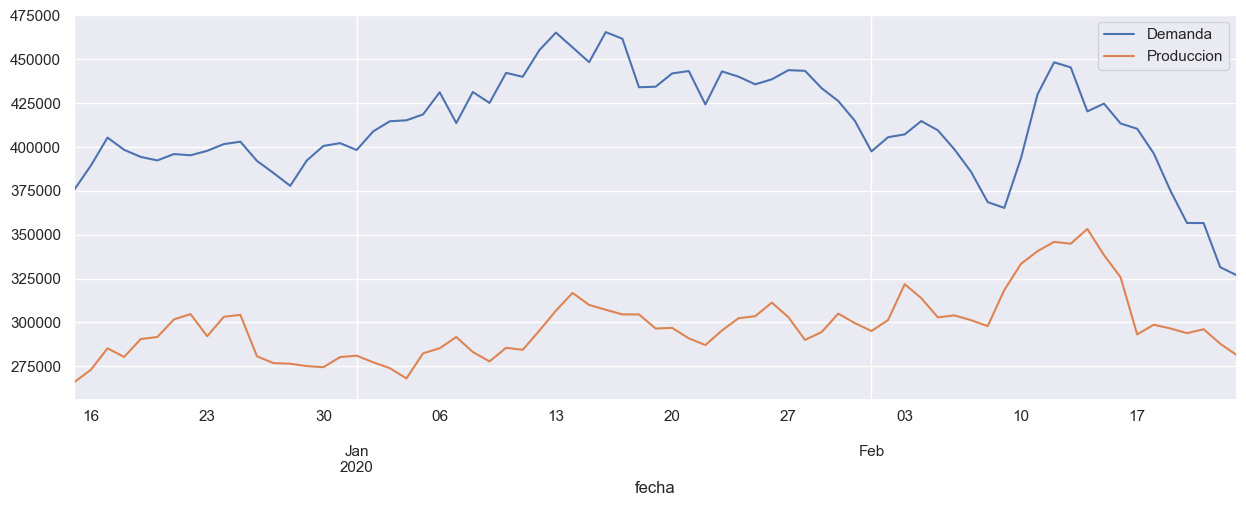

In [244]:
dataPreCovid.plot(figsize=(15,5))

In [245]:
dataCovid = data[data.index <= pd.to_datetime("30-04-2020")].copy()
dataCovid = dataCovid[pd.to_datetime("24-02-2020") <= dataCovid.index ]
dataCovid

,Demanda,Produccion
fecha,,
2020-02-24,314394,274931
2020-02-25,308539,261047
2020-02-26,313477,282819
2020-02-27,338249,294075
2020-02-28,332861,286547
...,...,...
2020-04-26,371136,325099
2020-04-27,344921,304380
2020-04-28,325709,300122


<Axes: xlabel='fecha'>

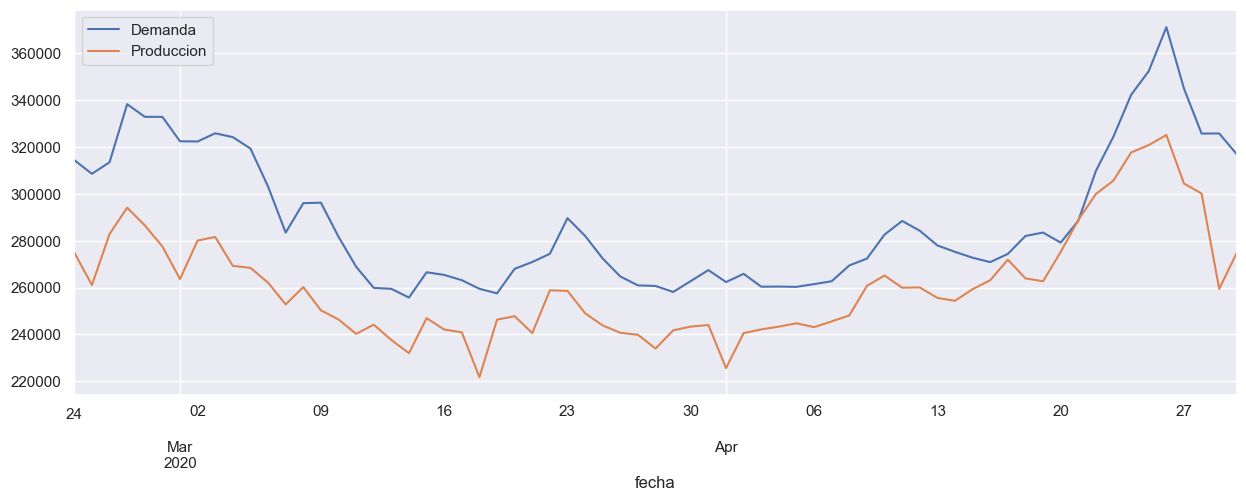

In [246]:
dataCovid.plot(figsize=(15,5))

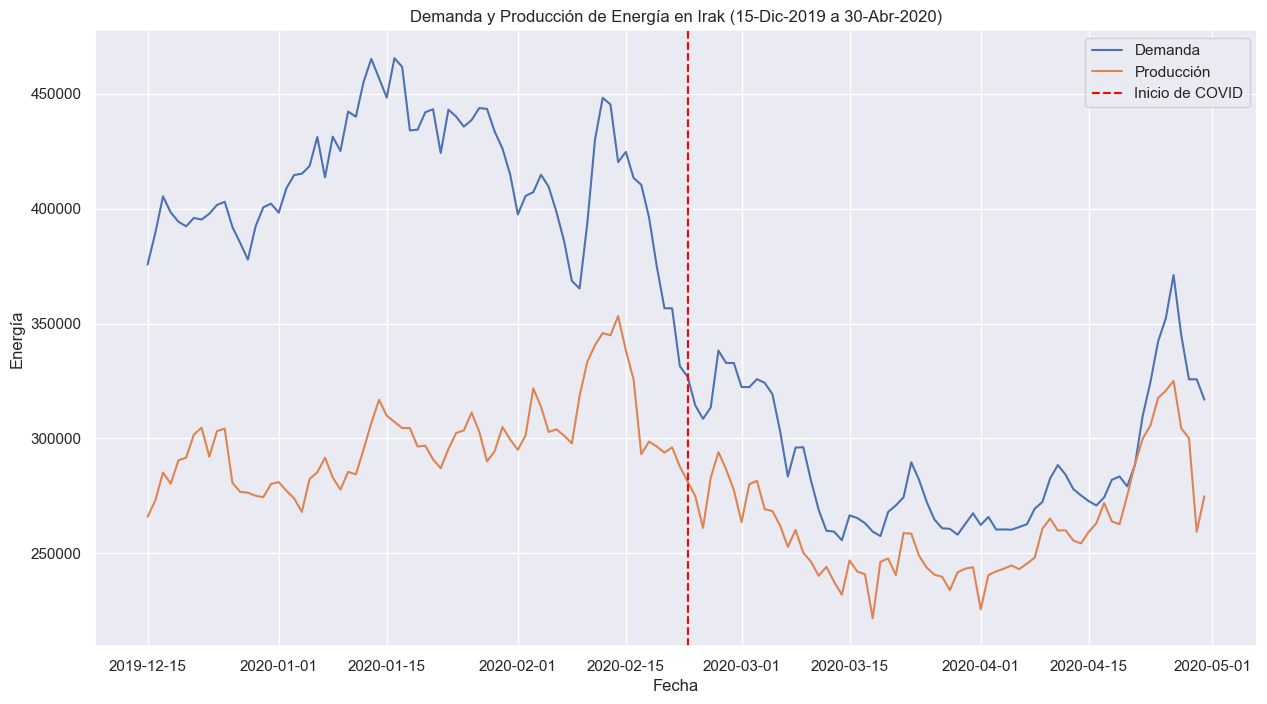

In [247]:
#dos meses antes del covid
data_filtered = data[(data.index >= pd.Timestamp("2019-12-15")) & (data.index <= pd.Timestamp("2020-04-30"))]
plt.figure(figsize=(15, 8))
plt.plot(data_filtered.index, data_filtered['Demanda'], label='Demanda')
plt.plot(data_filtered.index, data_filtered['Produccion'], label='Producción')
plt.axvline(pd.Timestamp("2020-02-23"), color='red', linestyle='--', label='Inicio de COVID')
plt.title('Demanda y Producción de Energía en Irak (15-Dic-2019 a 30-Abr-2020)')
plt.xlabel('Fecha')
plt.ylabel('Energía')
plt.legend()
plt.grid(True)
plt.show()


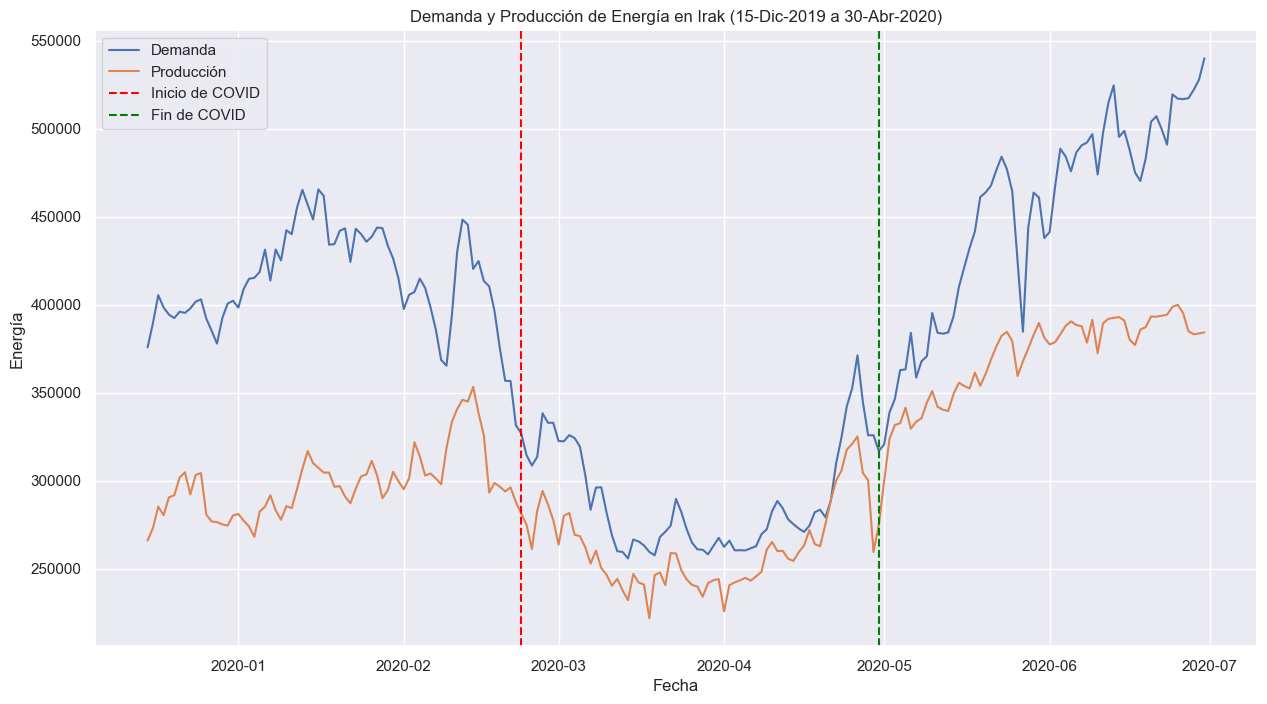

In [248]:
#dos meses antes del covid
data_filtered = data[(data.index >= pd.Timestamp("2019-12-15")) & (data.index <= pd.Timestamp("2020-06-30"))]
plt.figure(figsize=(15, 8))
plt.plot(data_filtered.index, data_filtered['Demanda'], label='Demanda')
plt.plot(data_filtered.index, data_filtered['Produccion'], label='Producción')
plt.axvline(pd.Timestamp("2020-02-23"), color='red', linestyle='--', label='Inicio de COVID')
plt.axvline(pd.Timestamp("2020-04-30"), color='green', linestyle='--', label='Fin de COVID')
plt.title('Demanda y Producción de Energía en Irak (15-Dic-2019 a 30-Abr-2020)')
plt.xlabel('Fecha')
plt.ylabel('Energía')
plt.legend()
plt.grid(True)
plt.show()


In [249]:
media_Covid_precovid = pd.DataFrame() 
datosCovid = {'Periodo': ['Pre-Covid','Covid principio'],
        'Media demanda': [dataPreCovid['Demanda'].mean(), dataCovid['Demanda'].mean()],
        'Media produccion': [dataPreCovid['Produccion'].mean(), dataCovid['Produccion'].mean()]}

media_Covid_precovid = pd.DataFrame(datosCovid)
media_Covid_precovid = media_Covid_precovid.set_index('Periodo')
media_Covid_precovid

,Media demanda,Media produccion
Periodo,,
Pre-Covid,412271.957746,297922.295775
Covid principio,288816.000000,261000.223881


Text(0, 0.5, 'Cuantidad')

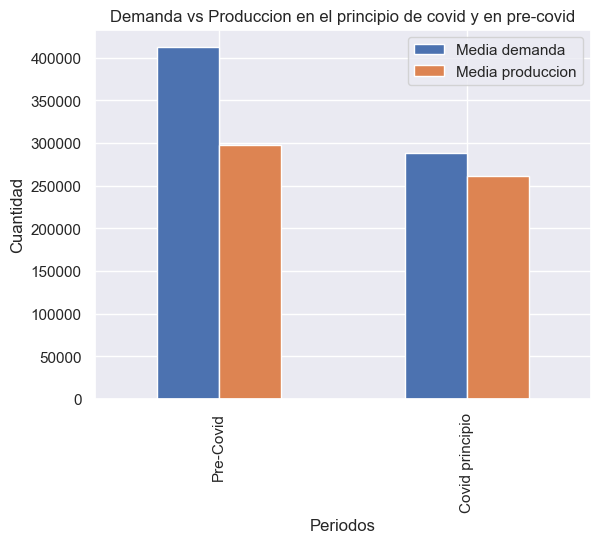

In [250]:
media_Covid_precovid.plot(kind="bar")
plt.title("Demanda vs Produccion en el principio de covid y en pre-covid")
plt.xlabel("Periodos")
plt.ylabel("Cuantidad")

# Festivo nacionales 

In [251]:
dataFestivos = data.copy()
dataFestivos

,Demanda,Produccion
fecha,,
2019-01-01,379726,289005
2019-01-02,383590,288843
2019-01-03,378901,283581
2019-01-04,378180,285621
2019-01-05,385805,283991
...,...,...
2021-12-26,466243,299610
2021-12-27,435243,291977
2021-12-28,420410,279246


In [252]:
dataEstacion

,Demanda,Produccion,estacion
fecha,,,
2019-01-01,379726,289005,Invierno
2019-01-02,383590,288843,Invierno
2019-01-03,378901,283581,Invierno
2019-01-04,378180,285621,Invierno
2019-01-05,385805,283991,Invierno
...,...,...,...
2021-12-26,466243,299610,Invierno
2021-12-27,435243,291977,Invierno
2021-12-28,420410,279246,Invierno


In [253]:
# Lista de días festivos
festivos = ["01-jan-2019", "06-jan-2019", "01-may-2019", "14-jul-2019", "03-oct-2019",
            "01-jan-2020", "06-jan-2020", "01-may-2020", "14-jul-2020", "03-oct-2020",
            "01-jan-2021", "06-jan-2021", "01-may-2021", "14-jul-2021", "03-oct-2021"]


# Crear una columna 'Festivo_Nacional' en el DataFrame
dataFestivos['Festivo_Nacional'] = dataFestivos.index.isin(festivos).astype(int)

In [254]:
dataEstacion['Festivo_Nacional'] = dataEstacion.index.isin(festivos)

In [255]:
dataEstacion

,Demanda,Produccion,estacion,Festivo_Nacional
fecha,,,,
2019-01-01,379726,289005,Invierno,True
2019-01-02,383590,288843,Invierno,False
2019-01-03,378901,283581,Invierno,False
2019-01-04,378180,285621,Invierno,False
2019-01-05,385805,283991,Invierno,False
...,...,...,...,...
2021-12-26,466243,299610,Invierno,False
2021-12-27,435243,291977,Invierno,False
2021-12-28,420410,279246,Invierno,False


In [256]:
dataFestivos

,Demanda,Produccion,Festivo_Nacional
fecha,,,
2019-01-01,379726,289005,1
2019-01-02,383590,288843,0
2019-01-03,378901,283581,0
2019-01-04,378180,285621,0
2019-01-05,385805,283991,0
...,...,...,...
2021-12-26,466243,299610,0
2021-12-27,435243,291977,0
2021-12-28,420410,279246,0


# Análisis de festivos 

In [257]:
Festivos_Nacionales = ["01-jan-2019" ,"06-jan-2019","01-may-2019","14-jul-2019","03-oct-2019","01-jan-2020" ,"06-jan-2020","01-may-2020","14-jul-2020","03-oct-2020","01-jan-2021" ,"06-jan-2021","01-may-2021","14-jul-2021","03-oct-2021"]
Festivos_Nacionales


['01-jan-2019',
 '06-jan-2019',
 '01-may-2019',
 '14-jul-2019',
 '03-oct-2019',
 '01-jan-2020',
 '06-jan-2020',
 '01-may-2020',
 '14-jul-2020',
 '03-oct-2020',
 '01-jan-2021',
 '06-jan-2021',
 '01-may-2021',
 '14-jul-2021',
 '03-oct-2021']

In [258]:
dataFestivo = data[data.index.isin(Festivos_Nacionales)]
dataFestivo


,Demanda,Produccion
fecha,,
2019-01-01,379726,289005
2019-01-06,378280,278314
2019-05-01,323099,262720
2019-07-14,493512,412650
2019-10-03,461922,375271
2020-01-01,398283,281007
2020-01-06,431218,285232
2020-05-01,320559,299753
2020-07-14,579399,400581


<Axes: xlabel='fecha'>

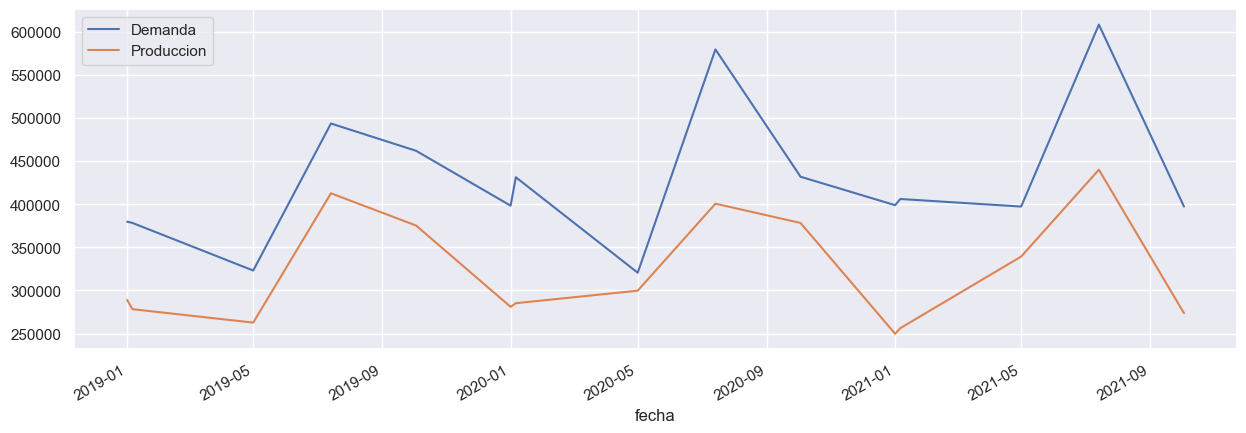

In [259]:
dataFestivo.plot(figsize=(15,5))

Text(0, 0.5, 'Energís(MW)')

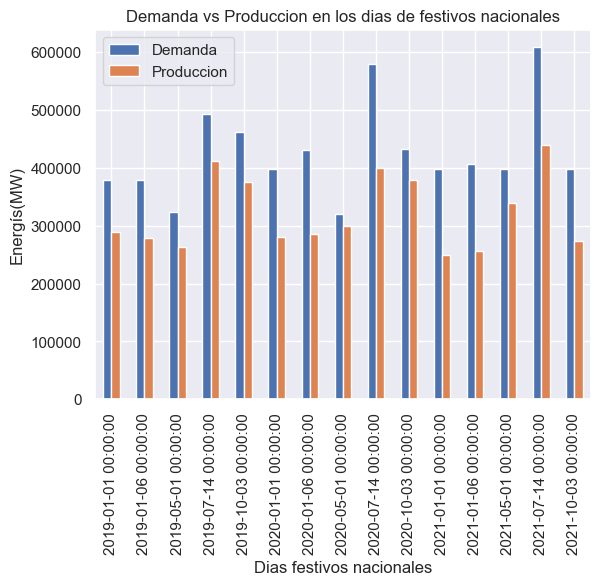

In [260]:
dataFestivo.plot(kind="bar")
plt.title("Demanda vs Produccion en los dias de festivos nacionales")
plt.xlabel("Dias festivos nacionales")
plt.ylabel("Energís(MW)")

In [261]:
dataTemporadasProduccion = dataEstacion.groupby('estacion').agg(media_produccion=('Produccion','mean')).reset_index()
dataTemporadasProduccion

,estacion,media_produccion
0,Invierno,268132.415978
1,Otoño,283917.808743
2,Primavera,306742.420765
3,Verano,403776.814208


In [262]:
dataTemporadasDemanda = dataEstacion.groupby('estacion').agg(media_Demanda=('Demanda','mean')).reset_index()
dataTemporadasDemanda

,estacion,media_Demanda
0,Invierno,367675.931129
1,Otoño,342338.863388
2,Primavera,365714.278689
3,Verano,540844.855191


In [263]:
dataTemporadas = pd.merge(dataTemporadasDemanda, dataTemporadasProduccion, on='estacion')
dataTemporadas = dataTemporadas.rename(columns={'Total_x': 'Demanda','Total_y': 'Produccion'})
dataTemporadas = dataTemporadas.set_index('estacion')
dataTemporadas

,media_Demanda,media_produccion
estacion,,
Invierno,367675.931129,268132.415978
Otoño,342338.863388,283917.808743
Primavera,365714.278689,306742.420765
Verano,540844.855191,403776.814208


Text(0, 0.5, 'Capacidad media')

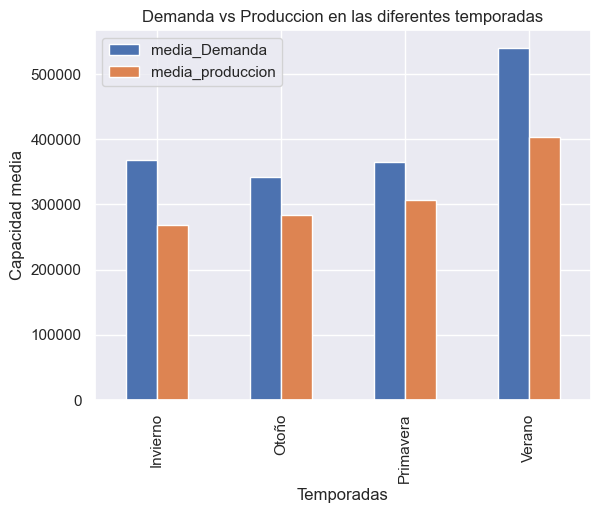

In [264]:
dataTemporadas.plot(kind="bar")
plt.title("Demanda vs Produccion en las diferentes temporadas")
plt.xlabel("Temporadas")
plt.ylabel("Capacidad media")

# Shaaban vs  Ramadan

In [265]:
data_shaaban_ramadan = data.copy()

In [266]:
data_shaaban_ramadan

,Demanda,Produccion
fecha,,
2019-01-01,379726,289005
2019-01-02,383590,288843
2019-01-03,378901,283581
2019-01-04,378180,285621
2019-01-05,385805,283991
...,...,...
2021-12-26,466243,299610
2021-12-27,435243,291977
2021-12-28,420410,279246


In [267]:
date_index = pd.date_range(start="01-01-2019", periods=len(data_shaaban_ramadan), freq='D')
data_shaaban_ramadan.index = date_index

In [268]:
data_shaaban_ramadan

,Demanda,Produccion
2019-01-01,379726,289005
2019-01-02,383590,288843
2019-01-03,378901,283581
2019-01-04,378180,285621
2019-01-05,385805,283991
...,...,...
2021-12-26,466243,299610
2021-12-27,435243,291977
2021-12-28,420410,279246
2021-12-29,411592,261122


In [269]:
periodos = pd.Series(0, index=data_shaaban_ramadan.index)
periodos[(pd.to_datetime("06-may-2019") <= periodos.index) & (periodos.index <= pd.to_datetime("04-jun-2019"))] = 1
periodos[(pd.to_datetime("06-apr-2019") <= periodos.index) & (periodos.index <= pd.to_datetime("05-may-2019"))] = 1
periodos[(pd.to_datetime("24-apr-2020") <= periodos.index) & (periodos.index <= pd.to_datetime("23-may-2020"))] = 1
periodos[(pd.to_datetime("25-mar-2020") <= periodos.index) & (periodos.index <= pd.to_datetime("23-apr-2020"))] = 1
periodos[(pd.to_datetime("13-apr-2021") <= periodos.index) & (periodos.index <= pd.to_datetime("12-may-2021"))] = 1
periodos[(pd.to_datetime("14-mar-2021") <= periodos.index) & (periodos.index <= pd.to_datetime("12-apr-2021"))] = 1
data_shaaban_ramadan['periodo'] = periodos

In [270]:
features = ['Demanda', 'Produccion', 'periodo']
train_data = data_shaaban_ramadan[features]['2019-01-01':'2020-12-31']
valid_data = data_shaaban_ramadan[features]['2021-01-01':]
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
valid_scaled = scaler.transform(valid_data)

In [271]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        dataX.append(dataset[i:(i + look_back), :-1])
        dataY.append(dataset[i + look_back, -1])
    return np.array(dataX), np.array(dataY)

In [272]:
look_back = 100
X_train, y_train = create_dataset(train_scaled, look_back)
X_valid, y_valid = create_dataset(valid_scaled, look_back)

In [273]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_valid, y_valid), verbose=2, shuffle=False)

Epoch 1/50


20/20 - 10s - loss: 0.6438 - accuracy: 0.6181 - val_loss: 0.3755 - val_accuracy: 0.8788 - 10s/epoch - 521ms/step
Epoch 2/50
20/20 - 2s - loss: 0.5166 - accuracy: 0.8177 - val_loss: 0.3090 - val_accuracy: 0.8788 - 2s/epoch - 80ms/step
Epoch 3/50
20/20 - 2s - loss: 0.4470 - accuracy: 0.8177 - val_loss: 0.3036 - val_accuracy: 0.8788 - 2s/epoch - 80ms/step
Epoch 4/50
20/20 - 2s - loss: 0.3938 - accuracy: 0.8177 - val_loss: 0.2692 - val_accuracy: 0.8788 - 2s/epoch - 81ms/step
Epoch 5/50
20/20 - 2s - loss: 0.3792 - accuracy: 0.8177 - val_loss: 0.2393 - val_accuracy: 0.8788 - 2s/epoch - 80ms/step
Epoch 6/50
20/20 - 2s - loss: 0.3538 - accuracy: 0.8177 - val_loss: 0.2033 - val_accuracy: 0.8788 - 2s/epoch - 81ms/step
Epoch 7/50
20/20 - 2s - loss: 0.3501 - accuracy: 0.8082 - val_loss: 0.2635 - val_accuracy: 0.8788 - 2s/epoch - 81ms/step
Epoch 8/50
20/20 - 2s - loss: 0.3119 - accuracy: 0.8304 - val_loss: 0.2804 - val_accuracy: 0.8788 - 2s/epoch - 83ms/step
Epoch 9/50
20/20 - 2s - loss: 0.3373 - a

In [274]:
y_pred_probs = model.predict(X_valid)
y_pred = (y_pred_probs > 0.6).astype(int).flatten()

9/9 [==============================] - 1s 27ms/step


In [275]:
real_days = y_valid[y_valid == 1]
predicted_days = y_pred[y_valid == 1]
accuracy = accuracy_score(real_days, predicted_days)
print(f"Accuracy: {accuracy * 100:.2f}%")
report = classification_report(real_days, predicted_days)
print(report)

Accuracy: 0.00%
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      32.0

    accuracy                           0.00      32.0
   macro avg       0.00      0.00      0.00      32.0
weighted avg       0.00      0.00      0.00      32.0



# Análisis exploratorio del Ramadan y el Shaa'ban

In [276]:
#2019
dataRamadan2019 = data[pd.to_datetime("06-may-2019") <= data.index ]
dataRamadan2019  = dataRamadan2019[dataRamadan2019.index <= pd.to_datetime("04-jun-2019")]

dataShaaban2019 = data[pd.to_datetime("06-apr-2019") <= data.index ]
dataShaaban2019  = dataShaaban2019[dataShaaban2019.index <= pd.to_datetime("05-may-2019")]

#2020
dataRamadan2020 = data[pd.to_datetime("24-apr-2020") <= data.index ]
dataRamadan2020  = dataRamadan2020[dataRamadan2020.index <= pd.to_datetime("23-may-2020")]

dataShaaban2020 = data[pd.to_datetime("25-mar-2020") <= data.index ]
dataShaaban2020  = dataShaaban2020[dataShaaban2020.index <= pd.to_datetime("23-apr-2020")]

#2021
dataRamadan2021 = data[pd.to_datetime("13-apr-2021") <= data.index ]
dataRamadan2021  = dataRamadan2021[dataRamadan2021.index <= pd.to_datetime("12-may-2021")]

dataShaaban2021 = data[pd.to_datetime("14-mar-2021") <= data.index ]
dataShaaban2021  = dataShaaban2021[dataShaaban2021.index <= pd.to_datetime("12-apr-2021")]


In [277]:
media_Chaaban_Ramadan = pd.DataFrame() 
datos = {'Epoca': ['Shaaban 2019','Ramadan 2019' ,'Shaaban 2020','Ramadan 2020', 'Shaaban 2021','Ramadan 2021'],
        'Media demanda': [dataShaaban2019['Demanda'].mean(), dataRamadan2019['Demanda'].mean(), dataShaaban2020['Demanda'].mean(), dataRamadan2020['Demanda'].mean(), dataShaaban2021['Demanda'].mean(),dataRamadan2021['Demanda'].mean()],
        'Media produccion': [dataShaaban2019['Produccion'].mean(), dataRamadan2019['Produccion'].mean(), dataShaaban2020['Produccion'].mean(), dataRamadan2020['Produccion'].mean(), dataShaaban2021['Produccion'].mean(),dataRamadan2021['Produccion'].mean()]}

media_Shaaban_Ramadan = pd.DataFrame(datos)
media_Shaaban_Ramadan = media_Shaaban_Ramadan.set_index('Epoca')
media_Shaaban_Ramadan

,Media demanda,Media produccion
Epoca,,
Shaaban 2019,286469.000000,238806.866667
Ramadan 2019,395727.033333,357752.066667
Shaaban 2020,273865.533333,255552.966667
Ramadan 2020,386320.000000,335347.600000
Shaaban 2021,288550.200000,240607.533333
Ramadan 2021,400432.066667,314738.500000


Text(0, 0.5, 'Media')

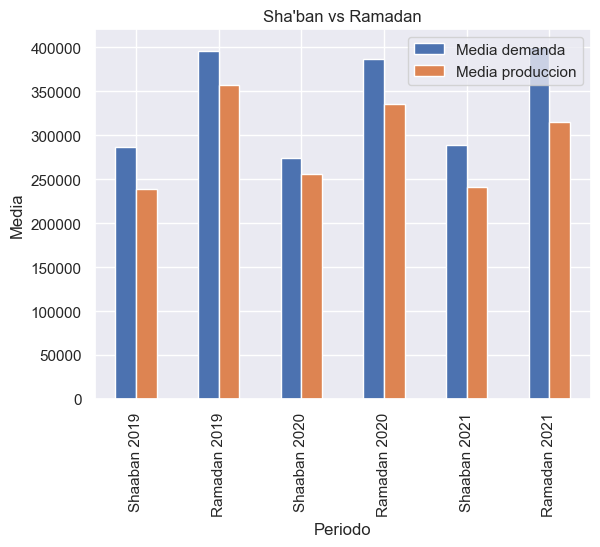

In [278]:
media_Shaaban_Ramadan.plot(kind="bar")
plt.title("Sha'ban vs Ramadan")
plt.xlabel("Periodo")
plt.ylabel("Media")

In [279]:
data.describe()

,Demanda,Produccion
count,1095.000000,1095.000000
mean,420994.799087,322561.829224
std,108713.245473,69567.326734
min,234522.000000,187266.000000
25%,325740.000000,258997.500000
50%,411592.000000,303169.000000
75%,498163.500000,391964.000000
max,664606.000000,453020.000000


Ya de primera podemos observar que vamos a tener dias donde la demanda supera a la produccion, y ademas de media siempre vamos a tener mayor demanda que produccion

In [280]:
dataMes= data.resample('m').sum()
dataMes

,Demanda,Produccion
fecha,,
2019-01-31,12344034,8892026
2019-02-28,10327355,7753904
2019-03-31,9566047,7603419
2019-04-30,8329040,6860510
2019-05-31,11823599,10597214
2019-06-30,14146614,11740792
2019-07-31,15465729,12511220
2019-08-31,15627938,12676743
2019-09-30,14477503,11977411


In [281]:
dataAno = data.resample('y').sum()
dataAno

,Demanda,Produccion
fecha,,
2019-12-31,143314874,116508462
2020-12-31,152389040,117898414
2021-12-31,165285391,118798327


<Axes: xlabel='fecha'>

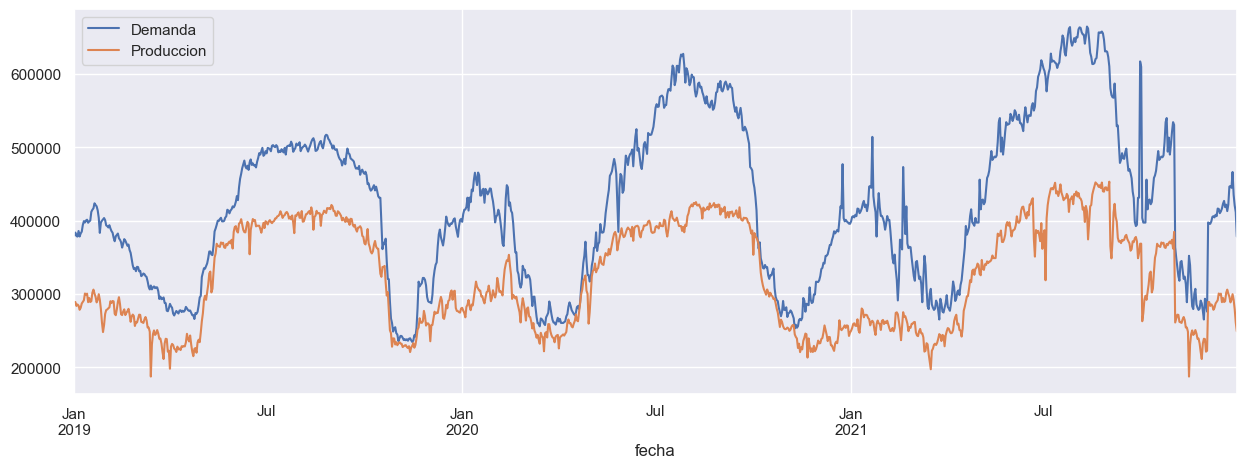

In [282]:
data.plot(figsize=(15,5))

<Axes: >

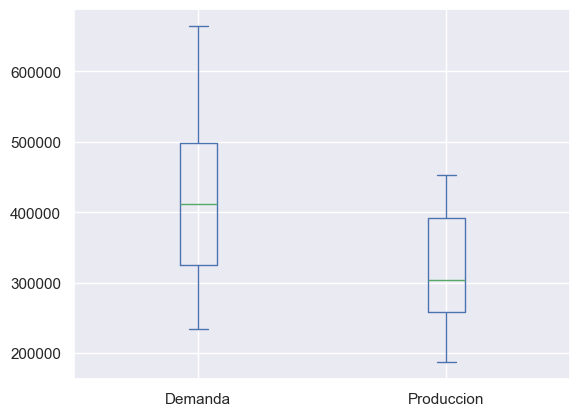

In [283]:
data.plot.box()

Vemos que la produccion nunca abaste la demanda, ademas nos fijamos que en los meses de verano siempre tenemos un pico de demanda que ademas aumenta con los años mientras que la produccion de mantiene

# Dickey-fuller

Vamos a pasar a comprobar si nuestra serie de tiempo es estacionario o no. Para ello vamos a seguir el modelo Dickey-Fuller

In [284]:
def test_stationarity(timeseries):
    
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Media móvil')
    std = plt.plot(rolstd, color='black', label = 'Desviacion estandar')
    plt.legend(loc='best')
    plt.title('Media móvil & Desviacion estandar')
    plt.show(block=False)
    
    print ('Resultados del Dickey-Fuller Test:')
   
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Estadístico de prueba','p-value','#Lags Used','Numero de observaciones'])
    for key,value in dftest[4].items():
        dfoutput['Valores criticos (%s)'%key] = value
    print(dfoutput)

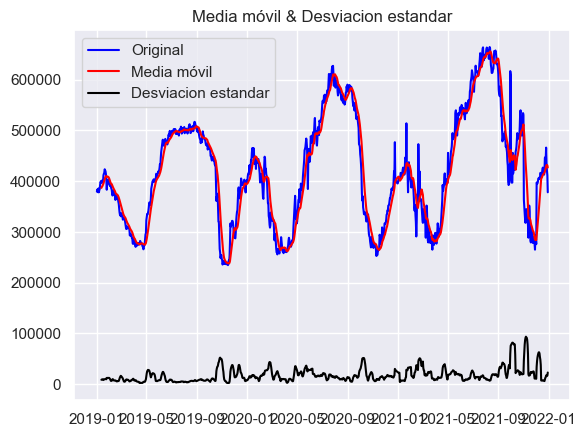

Resultados del Dickey-Fuller Test:
Estadístico de prueba        -3.080073
p-value                       0.028063
#Lags Used                   16.000000
Numero de observaciones    1078.000000
Valores criticos (1%)        -3.436431
Valores criticos (5%)        -2.864225
Valores criticos (10%)       -2.568200
dtype: float64


In [285]:
adfullerDemanda = test_stationarity(data['Demanda'])

Según estos resultados vemos observamos que podemos afirmar que al demanda es estacionario por diversos motivos, el p-value nos indica que tenemos una probabilidad muy baja del 2.68% de que los resultados observados en la serie de tiempo se deban al azar que nos indica que podemos rechazar la hipotesis nula. Luego el estadístico de prueba es menor que los valores críticos para los niveles de significación de 1% y 5% y no difiere mucho del 10% por lo que volvemos a rechazar la hipotesis nula. 

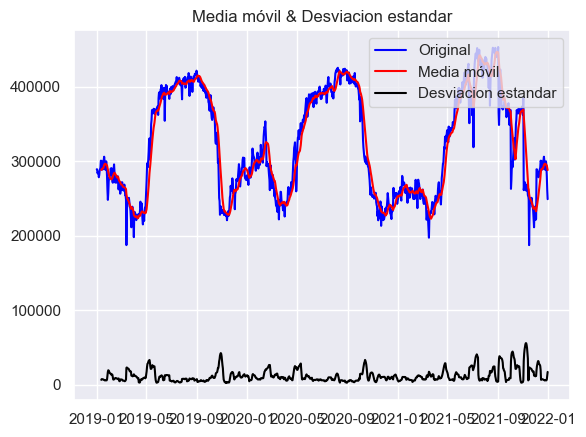

Resultados del Dickey-Fuller Test:
Estadístico de prueba        -2.022303
p-value                       0.276880
#Lags Used                    4.000000
Numero de observaciones    1090.000000
Valores criticos (1%)        -3.436364
Valores criticos (5%)        -2.864195
Valores criticos (10%)       -2.568184
dtype: float64


In [286]:
adfullerProduccion = test_stationarity(data['Produccion'])

Con la produccion vemos que ocurre todo lo contrario, el p-value es mayor que el valor de significancia del 0,05 y ademas nuestro estadistico de prueba es mayor que todos los valores criticos. Por lo cual decidimos que la serie de tiempo no es estacionaria.

# ARIMA 1

Sabiendo que la demanda si es estacionaria, vamos a aplicarle un modelo de  regresion autorregresiva integrada de media movil (ARIMA)

In [287]:
dataArima= dataMes['Demanda'].copy()


In [288]:
train_data_arima = dataArima[:int(len(dataArima)*0.8)].copy()
test_data_arima = dataArima[int(len(dataArima)*0.8):].copy()


In [289]:
def modelo_arima(p,d,q):
    model = ARIMA(train_data_arima, order=(p,d,q))
    model_fit = model.fit()
    print(model_fit.summary())

In [290]:
modelo_arima(1,1,1)
modelo_arima(2,1,1)
modelo_arima(2,1,2)


                               SARIMAX Results                                
Dep. Variable:                Demanda   No. Observations:                   28
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -436.052
Date:                Mon, 16 Oct 2023   AIC                            878.104
Time:                        14:41:03   BIC                            881.991
Sample:                    01-31-2019   HQIC                           879.260
                         - 04-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2176      1.231     -0.177      0.860      -2.631       2.196
ma.L1          0.3382      1.249      0.271      0.787      -2.109       2.786
sigma2      5.968e+12   4.28e-13   1.39e+25      0.0

Vamos a probar con una funcion que nos saca lo mejores valores

Vemos que el mejor AIC lo tiene el modelo para los valores (2,1,2)

In [291]:
modelfinal = ARIMA(train_data_arima, order=(2, 1, 2))
model_fit1 = modelfinal.fit()

In [292]:
forecast = model_fit1.forecast(steps=10)[0]

In [293]:
print(forecast)

11083110.036352286


In [294]:
predicciones = model_fit1.predict(start=len(train_data_arima), end=len(dataArima)-1, typ='levels')
predicciones

2021-05-31    1.108311e+07
2021-06-30    1.302891e+07
2021-07-31    1.414136e+07
2021-08-31    1.331580e+07
2021-09-30    1.140824e+07
2021-10-31    1.034849e+07
2021-11-30    1.118810e+07
2021-12-31    1.305750e+07
Freq: M, Name: predicted_mean, dtype: float64

In [295]:
errorARIMA = np.mean(np.abs((test_data_arima - predicciones) / test_data_arima)) * 100
accuracyARIMA = 100 - errorARIMA
mseARIMA = mean_squared_error(test_data_arima, predicciones)

In [296]:
print(f"Precision modelo ARIMA es: {accuracyARIMA}" )
print(f"El error es: {errorARIMA}")
print(f"El error cuadrático mse: {mseARIMA} kw")

Precision modelo ARIMA es: 76.83425149151572
El error es: 23.165748508484292
El error cuadrático mse: 16757263208066.627 kw


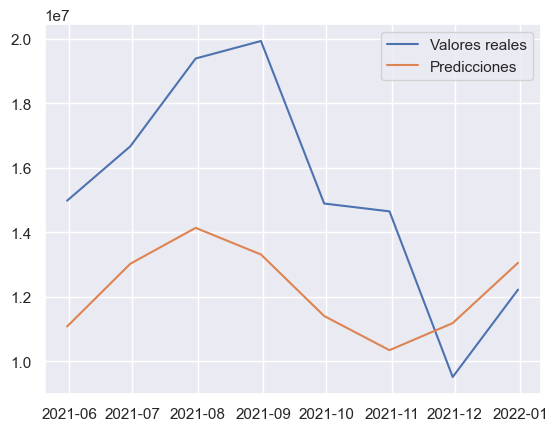

In [297]:
plt.plot(dataArima.index[int(len(dataArima)*0.8):], test_data_arima, label='Valores reales')
plt.plot(dataArima.index[int(len(dataArima)*0.8):], predicciones, label='Predicciones')
plt.legend()
plt.show()

# ARIMA 2

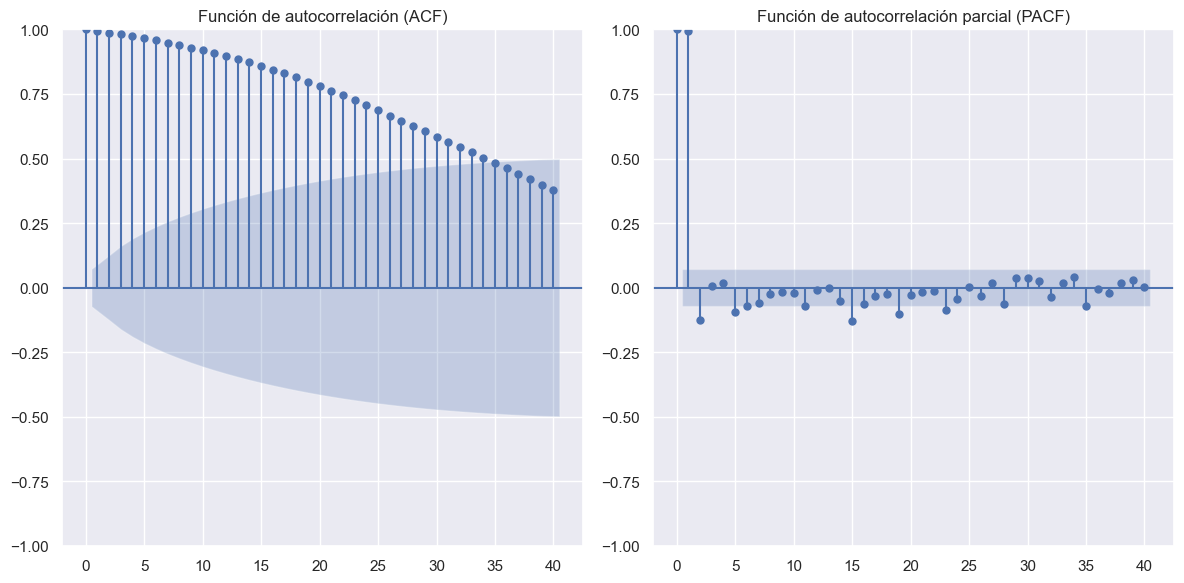

In [298]:
dataArima = data['Demanda'].copy()

train_data_arima = dataArima['2019-01-01':'2020-12-31'].copy()
test_data_arima = dataArima['2021-01-01':'2021-12-31'].copy()

def modelo_arima(p, d, q):
    model = ARIMA(train_data_arima, order=(p, d, q))
    model_fit = model.fit()
    print(model_fit.summary())
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(train_data_arima, lags=40, ax=plt.gca())
plt.title('Función de autocorrelación (ACF)')
plt.subplot(122)
plot_pacf(train_data_arima, lags=40, ax=plt.gca())
plt.title('Función de autocorrelación parcial (PACF)')
plt.tight_layout()
plt.show()




In [299]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
aic_values = []
for param in pdq:
    try:
        model = ARIMA(train_data_arima, order=param)
        model_fit = model.fit()
        aic_values.append((param, model_fit.aic))
    except:
        continue
best_param = min(aic_values, key=lambda x: x[1])
best_param

((1, 1, 2), 15590.235245388272)

In [300]:
modelo_arima(1, 1, 2)


                               SARIMAX Results                                
Dep. Variable:                Demanda   No. Observations:                  731
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -7791.118
Date:                Mon, 16 Oct 2023   AIC                          15590.235
Time:                        14:41:10   BIC                          15608.607
Sample:                    01-01-2019   HQIC                         15597.323
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9433      0.057     16.561      0.000       0.832       1.055
ma.L1         -0.8972      0.057    -15.795      0.000      -1.009      -0.786
ma.L2         -0.0272      0.019     -1.403      0.1

## Parametrizaciones 

In [402]:
dataset= 'demanda_data.csv'

In [415]:
def parametrizaciones(dataset, look_back, config):
    dataset = pd.read_csv(dataset)
    start_date = datetime(2019, 1, 1)
    end_date = datetime(2021, 12, 31)
    delta = timedelta(days=1)
    dates = pd.date_range(start_date, end_date, freq=delta)
    dates = dates[:-1]
    dataset['Date'] = dates
    dataset = dataset.set_index('Date')
    train_data = dataset.loc[:'2020-12-31']
    test_data = dataset.loc['2021-01-01':]
    
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)

    X_train, y_train, X_test, y_test = [], [], [], []
    for i in range(look_back, len(train_scaled)):
        X_train.append(train_scaled[i-look_back:i, 0])
        y_train.append(train_scaled[i, 0])
    for i in range(look_back, len(test_scaled)):
        X_test.append(test_scaled[i-look_back:i, 0])
        y_test.append(test_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    model = Sequential()
    for i in range(config['layers']):
        return_seq = True if i < config['layers'] - 1 else config['return_sequence']
        model.add(LSTM(units=config['units'], return_sequences=return_seq, recurrent_dropout=config['recurrent_dropout']))
    for units in config['dense_layers']:
        model.add(Dense(units=units))
        model.add(Dropout(config['dense_dropout']))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=50, batch_size=32)
    
    predicted_values = model.predict(X_test)
    if not config['return_sequence']:
        predicted_values = predicted_values[1:]
    predicted_values = scaler.inverse_transform(np.reshape(predicted_values, (-1, 1)))
    real_values = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    if len(predicted_values) != len(real_values):
        min_len = min(len(predicted_values), len(real_values))
        predicted_values = predicted_values[:min_len]
        real_values = real_values[:min_len]
        
    mae = mean_absolute_error(real_values, predicted_values)
    mse = mean_squared_error(real_values, predicted_values)
    threshold = 0.05
    correct_predictions = np.abs(predicted_values - real_values) <= threshold * real_values
    accuracy = np.mean(correct_predictions)
    test_dates = test_data.index[look_back:]
    min_len = min(len(test_dates), len(real_values), len(predicted_values))
    test_dates = test_dates[:min_len]
    real_values = real_values[:min_len]
    predicted_values = predicted_values[:min_len]
    
    print(f"Valor MAE : {mae}")
    print(f"Valor MSE: {mse}")
    print(f"Precisión según el umbral {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(test_dates, real_values.flatten(), linestyle='-', label='Valores reales')
    plt.plot(test_dates, predicted_values.flatten(), linestyle='-', label='Valores predichos')
    plt.title('Comparación valores reales vs valores predichos')
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.legend()
    plt.show()
    
    return model, history




Epoch 1/50


23/23 [==============================] - 5s 14ms/step - loss: 0.0426
Epoch 2/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0115
Epoch 3/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0079
Epoch 4/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0062
Epoch 5/50
23/23 [==============================] - 0s 11ms/step - loss: 0.0061
Epoch 6/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0057
Epoch 7/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0052
Epoch 8/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0045
Epoch 9/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0046
Epoch 10/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0036
Epoch 11/50
23/23 [==============================] - 0s 11ms/step - loss: 0.0036
Epoch 12/50
23/23 [==============================] - 0s 11ms/step - loss: 0.0035
Epoch 13/50
23/23 [=============================

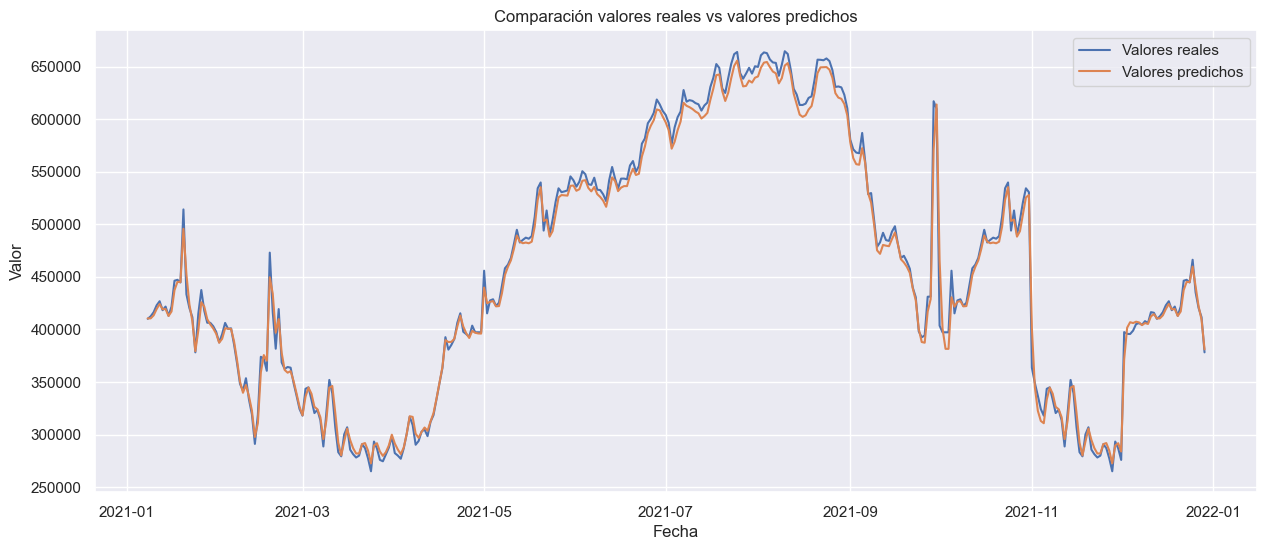

(<keras.src.engine.sequential.Sequential at 0x1eea01069e0>,
 <keras.src.callbacks.History at 0x1eeb54ab4f0>)

In [417]:
config1 = {
    'layers': 1,
    'units': 128,
    'return_sequence': False,
    'recurrent_dropout': 0,
    'dense_dropout': 0.2,
    'dense_layers': [32, 64, 128]
}
parametrizaciones(dataset, 7, config1)

Epoch 1/50
23/23 [==============================] - 5s 23ms/step - loss: 0.0381
Epoch 2/50
23/23 [==============================] - 1s 24ms/step - loss: 0.0065
Epoch 3/50
23/23 [==============================] - 1s 23ms/step - loss: 0.0050
Epoch 4/50
23/23 [==============================] - 0s 21ms/step - loss: 0.0048
Epoch 5/50
23/23 [==============================] - 1s 22ms/step - loss: 0.0041
Epoch 6/50
23/23 [==============================] - 1s 25ms/step - loss: 0.0036
Epoch 7/50
23/23 [==============================] - 1s 23ms/step - loss: 0.0034
Epoch 8/50
23/23 [==============================] - 1s 28ms/step - loss: 0.0037
Epoch 9/50
23/23 [==============================] - 1s 27ms/step - loss: 0.0038
Epoch 10/50
23/23 [==============================] - 1s 22ms/step - loss: 0.0029
Epoch 11/50
23/23 [==============================] - 0s 21ms/step - loss: 0.0026
Epoch 12/50
23/23 [==============================] - 1s 23ms/step - loss: 0.0028
Epoch 13/50
23/23 [==================

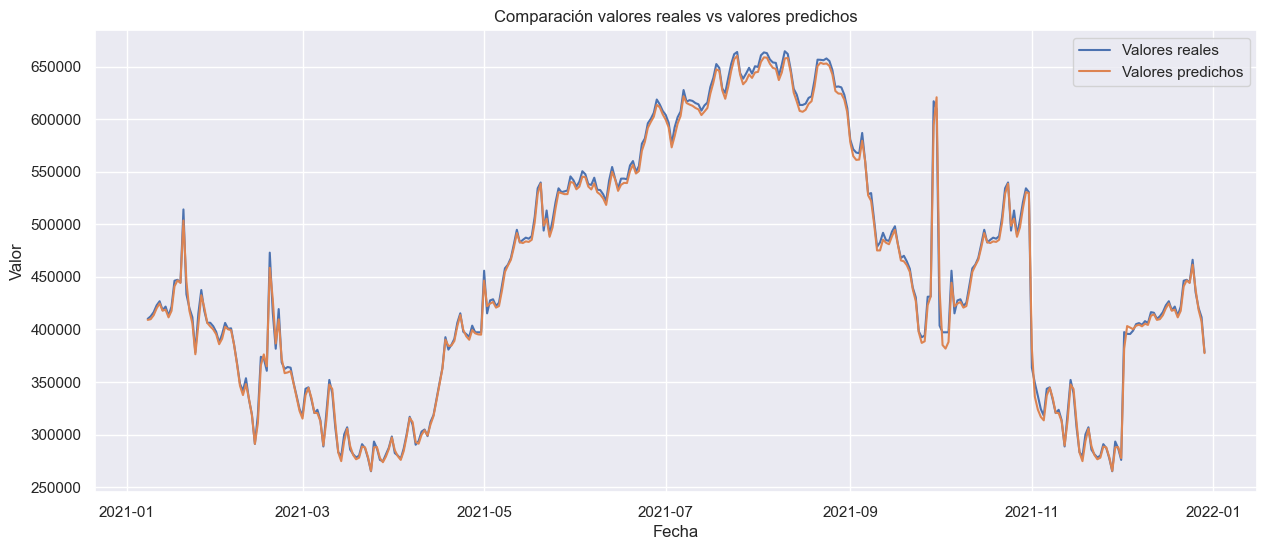

(<keras.src.engine.sequential.Sequential at 0x1eeb8324610>,
 <keras.src.callbacks.History at 0x1eeb99ce5f0>)

In [416]:
config2 = {
    'layers': 1,
    'units': 256,
    'return_sequence': False,
    'recurrent_dropout': 0,
    'dense_dropout': 0.2,
    'dense_layers': [64, 128]
}
parametrizaciones(dataset, 7, config2)

Epoch 1/50
23/23 [==============================] - 7s 23ms/step - loss: 0.1094
Epoch 2/50
23/23 [==============================] - 0s 20ms/step - loss: 0.0697
Epoch 3/50
23/23 [==============================] - 0s 20ms/step - loss: 0.0687
Epoch 4/50
23/23 [==============================] - 0s 20ms/step - loss: 0.0687
Epoch 5/50
23/23 [==============================] - 0s 19ms/step - loss: 0.0681
Epoch 6/50
23/23 [==============================] - 0s 20ms/step - loss: 0.0677
Epoch 7/50
23/23 [==============================] - 0s 20ms/step - loss: 0.0686
Epoch 8/50
23/23 [==============================] - 0s 21ms/step - loss: 0.0688
Epoch 9/50
23/23 [==============================] - 0s 19ms/step - loss: 0.0677
Epoch 10/50
23/23 [==============================] - 0s 20ms/step - loss: 0.0676
Epoch 11/50
23/23 [==============================] - 0s 21ms/step - loss: 0.0682
Epoch 12/50
23/23 [==============================] - 0s 20ms/step - loss: 0.0676
Epoch 13/50
23/23 [==================

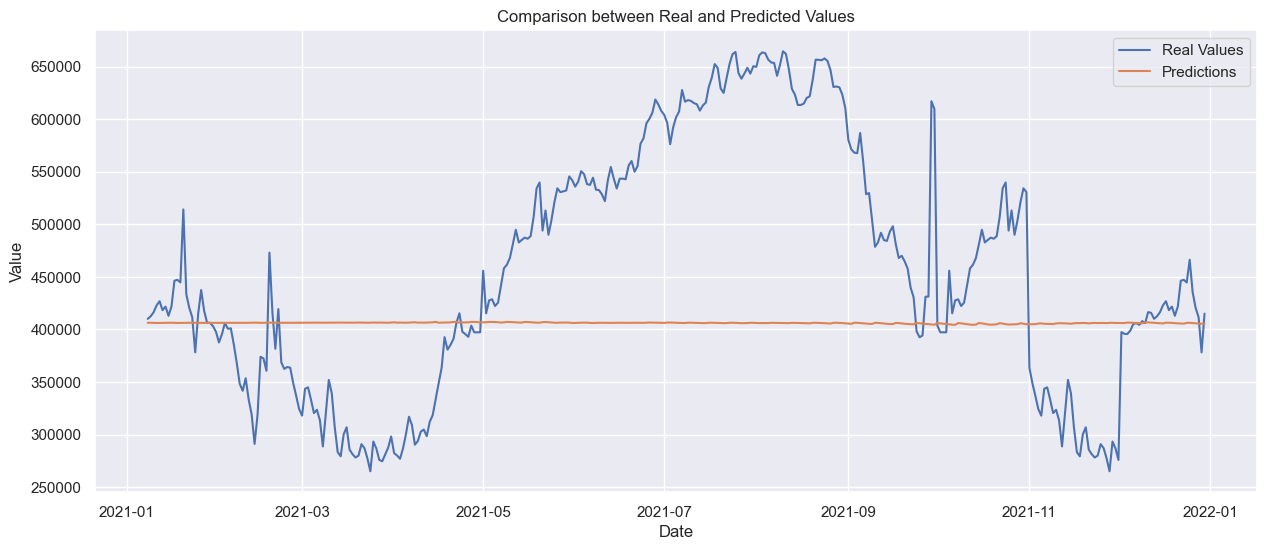

(<keras.src.engine.sequential.Sequential at 0x1eea206d4b0>,
 <keras.src.callbacks.History at 0x1eebb833fa0>)

In [407]:
config3 = {
    'layers': 2,
    'units': 128,
    'return_sequence': True,
    'recurrent_dropout': 0,
    'dense_dropout': 0.2,
    'dense_layers': [32, 64]
}
parametrizaciones(dataset, 7, config3)

Epoch 1/50
23/23 [==============================] - 4s 12ms/step - loss: 0.0293
Epoch 2/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0061
Epoch 3/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0046
Epoch 4/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0046
Epoch 5/50
23/23 [==============================] - 0s 14ms/step - loss: 0.0045
Epoch 6/50
23/23 [==============================] - 0s 15ms/step - loss: 0.0039
Epoch 7/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0039
Epoch 8/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0040
Epoch 9/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0036
Epoch 10/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0035
Epoch 11/50
23/23 [==============================] - 0s 14ms/step - loss: 0.0038
Epoch 12/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0035
Epoch 13/50
23/23 [==================

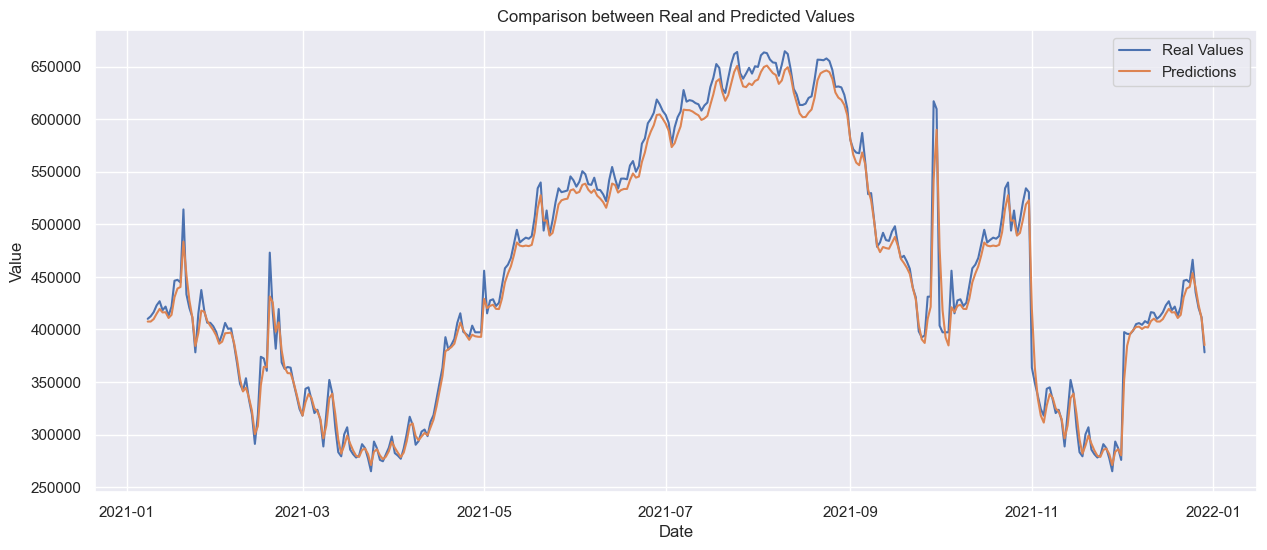

(<keras.src.engine.sequential.Sequential at 0x1eeb99e58a0>,
 <keras.src.callbacks.History at 0x1eebfb79240>)

In [408]:
config4 = {
    'layers': 1,
    'units': 128,
    'return_sequence': False,
    'recurrent_dropout': 0.2,
    'dense_dropout': 0.3,
    'dense_layers': [64]
}
parametrizaciones(dataset, 7, config4)

Epoch 1/50
23/23 [==============================] - 5s 14ms/step - loss: 0.0323
Epoch 2/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0100
Epoch 3/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0106
Epoch 4/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0072
Epoch 5/50
23/23 [==============================] - 0s 14ms/step - loss: 0.0064
Epoch 6/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0061
Epoch 7/50
23/23 [==============================] - 0s 11ms/step - loss: 0.0056
Epoch 8/50
23/23 [==============================] - 0s 11ms/step - loss: 0.0050
Epoch 9/50
23/23 [==============================] - 0s 10ms/step - loss: 0.0050
Epoch 10/50
23/23 [==============================] - 0s 10ms/step - loss: 0.0048
Epoch 11/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0046
Epoch 12/50
23/23 [==============================] - 0s 10ms/step - loss: 0.0041
Epoch 13/50
23/23 [==================

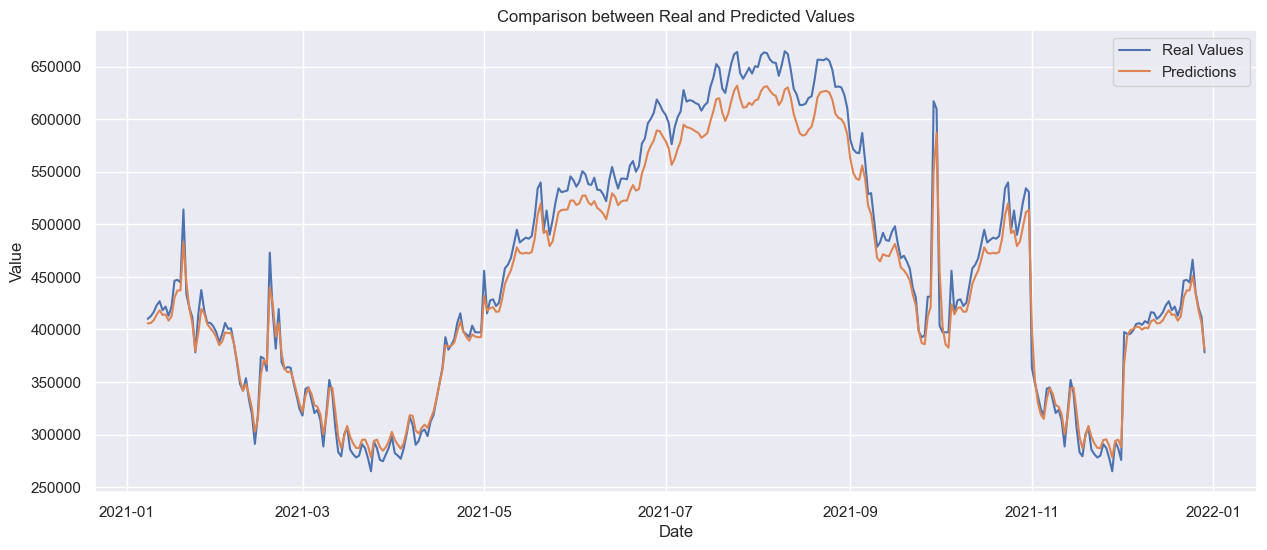

(<keras.src.engine.sequential.Sequential at 0x1eebfba0400>,
 <keras.src.callbacks.History at 0x1eec15e41c0>)

In [409]:
config5 = {
    'layers': 1,
    'units': 128,
    'return_sequence': False,
    'recurrent_dropout': 0,
    'dense_dropout': 0.2,
    'dense_layers': [32, 64, 128, 64]
}
parametrizaciones(dataset, 7, config5)

Epoch 1/50
23/23 [==============================] - 4s 7ms/step - loss: 0.0640
Epoch 2/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0073
Epoch 3/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0028
Epoch 4/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0023
Epoch 5/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0022
Epoch 6/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 7/50
23/23 [==============================] - 0s 10ms/step - loss: 0.0022
Epoch 8/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0021
Epoch 9/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 10/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 11/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 12/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 13/50
23/23 [=============================

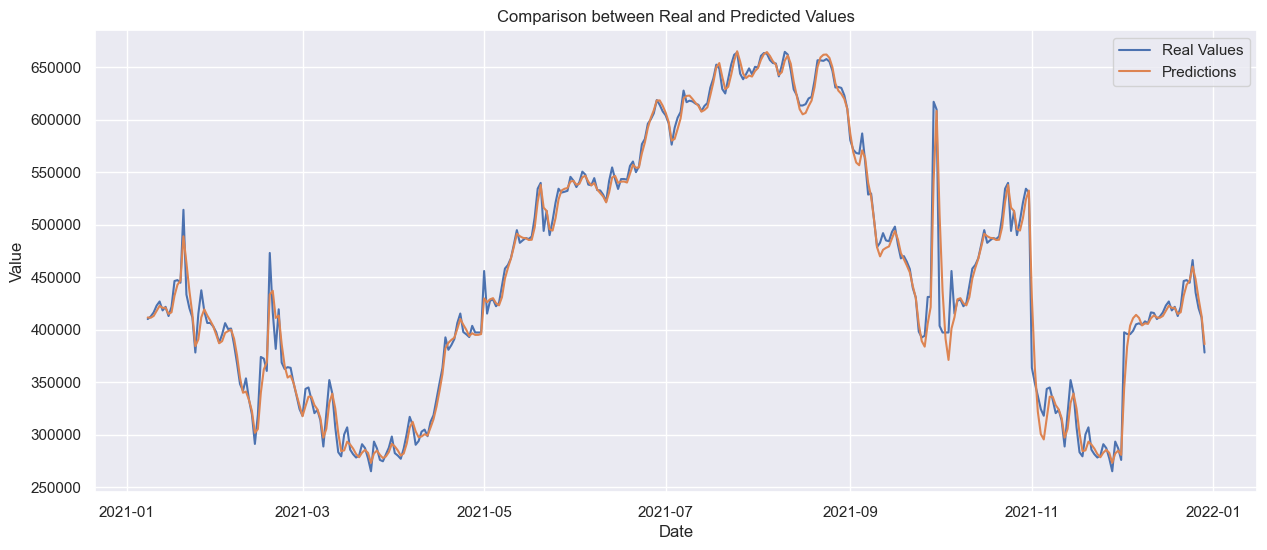

(<keras.src.engine.sequential.Sequential at 0x1eebafeeb00>,
 <keras.src.callbacks.History at 0x1eec5a455d0>)

In [410]:
config6 = {
    'layers': 1,
    'units': 64,
    'return_sequence': False,
    'recurrent_dropout': 0,
    'dense_dropout': 0,
    'dense_layers': [32]
}
parametrizaciones(dataset, 7, config6)

Epoch 1/50
23/23 [==============================] - 15s 150ms/step - loss: 0.0975
Epoch 2/50
23/23 [==============================] - 3s 148ms/step - loss: 0.0693
Epoch 3/50
23/23 [==============================] - 3s 151ms/step - loss: 0.0685
Epoch 4/50
23/23 [==============================] - 3s 148ms/step - loss: 0.0684
Epoch 5/50
23/23 [==============================] - 4s 160ms/step - loss: 0.0682
Epoch 6/50
23/23 [==============================] - 4s 165ms/step - loss: 0.0676
Epoch 7/50
23/23 [==============================] - 4s 153ms/step - loss: 0.0685
Epoch 8/50
23/23 [==============================] - 4s 151ms/step - loss: 0.0696
Epoch 9/50
23/23 [==============================] - 3s 152ms/step - loss: 0.0679
Epoch 10/50
23/23 [==============================] - 4s 154ms/step - loss: 0.0679
Epoch 11/50
23/23 [==============================] - 3s 150ms/step - loss: 0.0687
Epoch 12/50
23/23 [==============================] - 3s 150ms/step - loss: 0.0678
Epoch 13/50
23/23 [=====

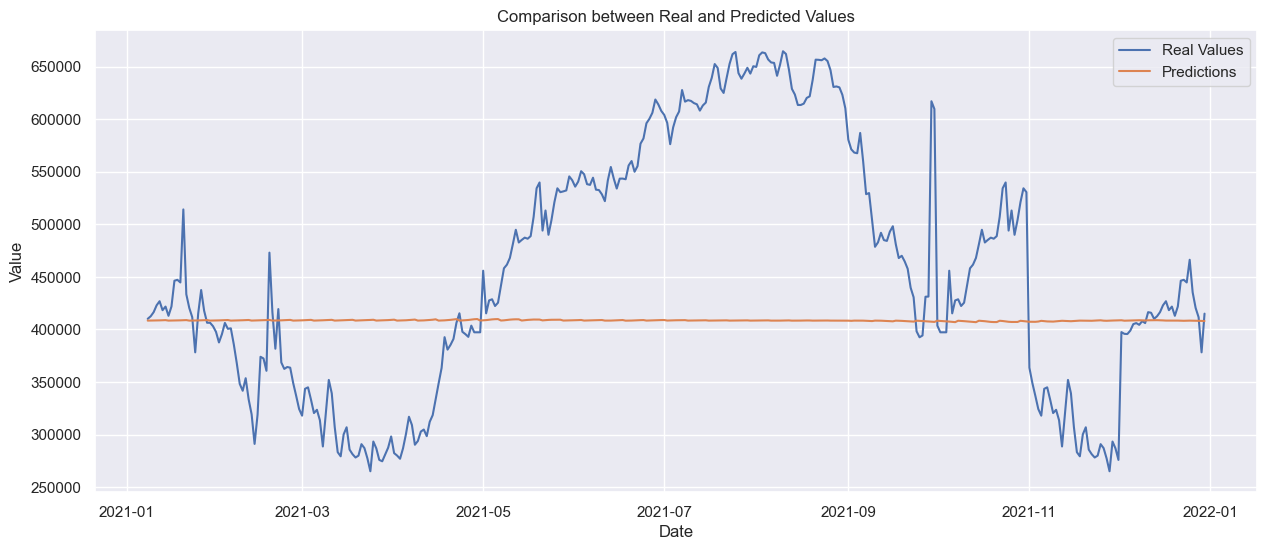

(<keras.src.engine.sequential.Sequential at 0x1ee89accbb0>,
 <keras.src.callbacks.History at 0x1eec7361c30>)

In [411]:
config7 = {
    'layers': 3,
    'units': 256,
    'return_sequence': True,
    'recurrent_dropout': 0.2,
    'dense_dropout': 0.2,
    'dense_layers': [128, 64]
}
parametrizaciones(dataset, 7, config7)

Epoch 1/50
23/23 [==============================] - 3s 7ms/step - loss: 0.0356
Epoch 2/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0048
Epoch 3/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0023
Epoch 4/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 5/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 6/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 7/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 8/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 9/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 10/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 11/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 12/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 13/50
23/23 [==============================

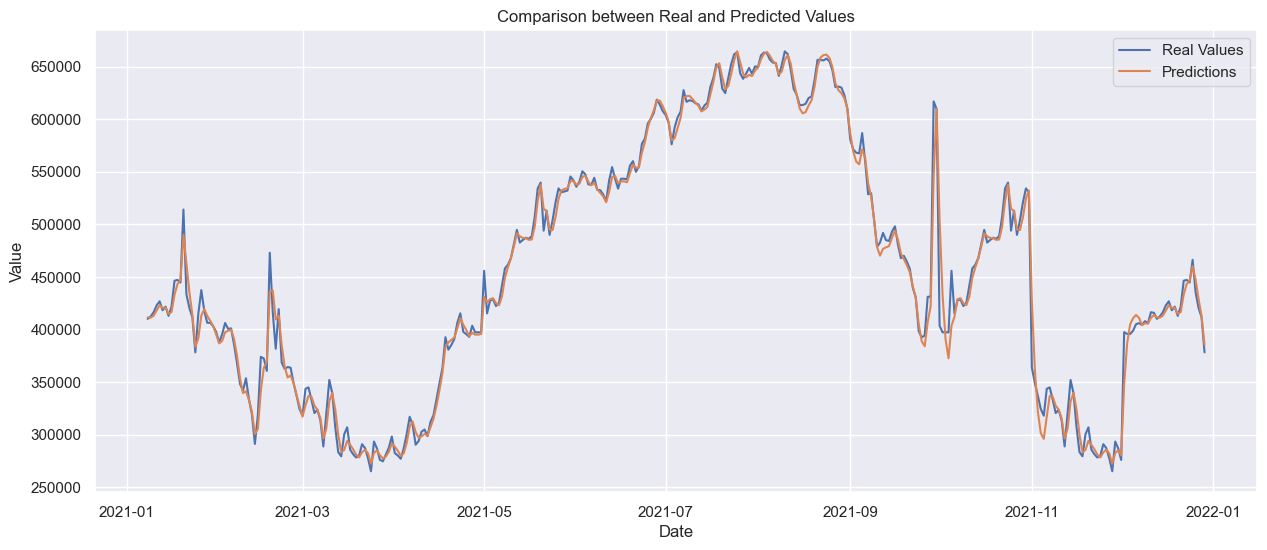

(<keras.src.engine.sequential.Sequential at 0x1eeb7ff9180>,
 <keras.src.callbacks.History at 0x1eecd5c6fb0>)

In [412]:
config8 = {
    'layers': 1,
    'units': 64,
    'return_sequence': False,
    'recurrent_dropout': 0,
    'dense_dropout': 0,
    'dense_layers': [32]
}
parametrizaciones(dataset, 7, config8)

Epoch 1/50
23/23 [==============================] - 7s 25ms/step - loss: 0.1089
Epoch 2/50
23/23 [==============================] - 1s 25ms/step - loss: 0.0705
Epoch 3/50
23/23 [==============================] - 1s 24ms/step - loss: 0.0694
Epoch 4/50
23/23 [==============================] - 1s 24ms/step - loss: 0.0696
Epoch 5/50
23/23 [==============================] - 1s 25ms/step - loss: 0.0692
Epoch 6/50
23/23 [==============================] - 1s 25ms/step - loss: 0.0687
Epoch 7/50
23/23 [==============================] - 1s 24ms/step - loss: 0.0693
Epoch 8/50
23/23 [==============================] - 1s 24ms/step - loss: 0.0701
Epoch 9/50
23/23 [==============================] - 1s 25ms/step - loss: 0.0688
Epoch 10/50
23/23 [==============================] - 1s 24ms/step - loss: 0.0688
Epoch 11/50
23/23 [==============================] - 1s 24ms/step - loss: 0.0691
Epoch 12/50
23/23 [==============================] - 1s 25ms/step - loss: 0.0685
Epoch 13/50
23/23 [==================

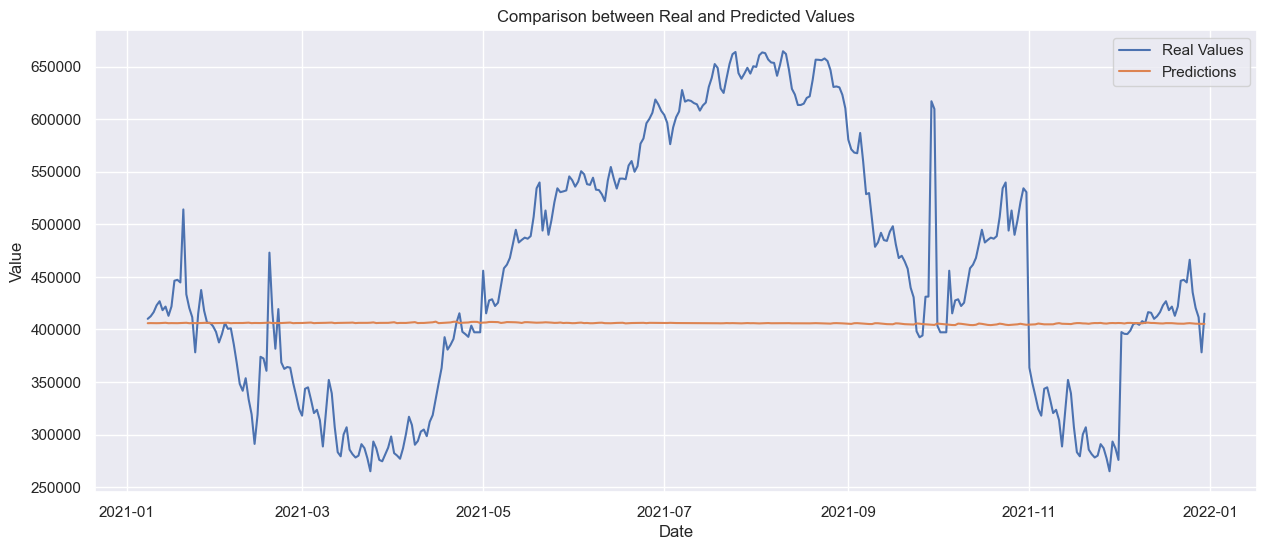

(<keras.src.engine.sequential.Sequential at 0x1eec7270fa0>,
 <keras.src.callbacks.History at 0x1eed9566140>)

In [413]:
config9 = {
    'layers': 2,
    'units': 128,
    'return_sequence': True,
    'recurrent_dropout': 0.1,
    'dense_dropout': 0.2,
    'dense_layers': [64, 32]
}
parametrizaciones(dataset, 7, config9)

Epoch 1/50
23/23 [==============================] - 11s 32ms/step - loss: 0.0393
Epoch 2/50
23/23 [==============================] - 1s 29ms/step - loss: 0.0087
Epoch 3/50
23/23 [==============================] - 1s 29ms/step - loss: 0.0070
Epoch 4/50
23/23 [==============================] - 1s 30ms/step - loss: 0.0070
Epoch 5/50
23/23 [==============================] - 1s 35ms/step - loss: 0.0064
Epoch 6/50
23/23 [==============================] - 1s 23ms/step - loss: 0.0052
Epoch 7/50
23/23 [==============================] - 1s 24ms/step - loss: 0.0057
Epoch 8/50
23/23 [==============================] - 1s 23ms/step - loss: 0.0060
Epoch 9/50
23/23 [==============================] - 1s 33ms/step - loss: 0.0053
Epoch 10/50
23/23 [==============================] - 1s 27ms/step - loss: 0.0059
Epoch 11/50
23/23 [==============================] - 1s 28ms/step - loss: 0.0052
Epoch 12/50
23/23 [==============================] - 1s 27ms/step - loss: 0.0054
Epoch 13/50
23/23 [=================

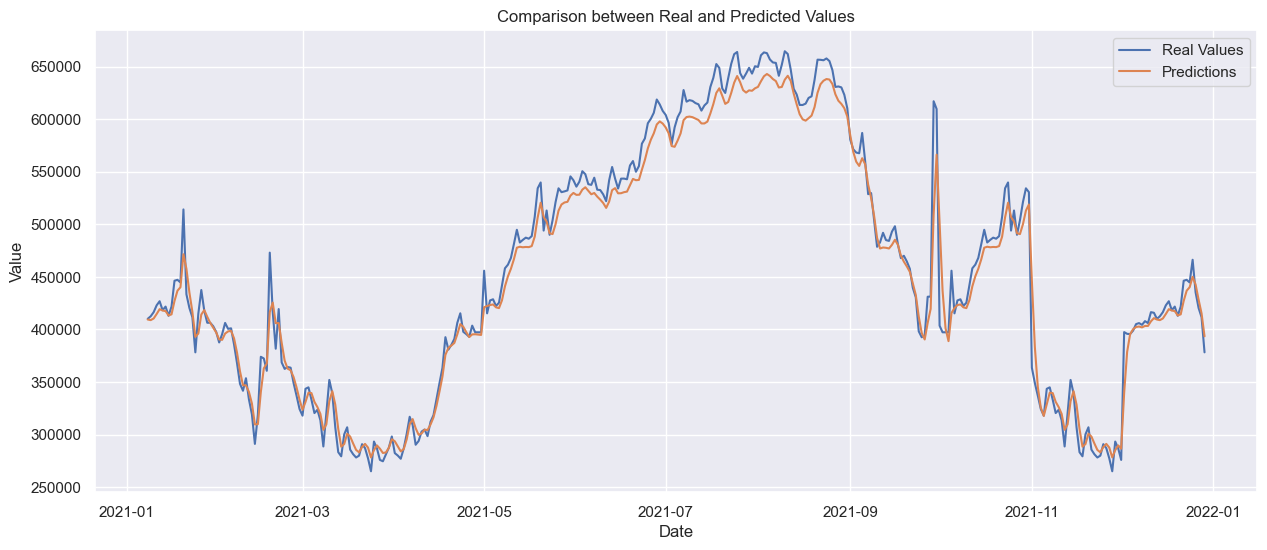

(<keras.src.engine.sequential.Sequential at 0x1eec15e40d0>,
 <keras.src.callbacks.History at 0x1eedb19c1f0>)

In [414]:
config10 = {
    'layers': 2,
    'units': 128,
    'return_sequence': False,
    'recurrent_dropout': 0.3,
    'dense_dropout': 0.4,
    'dense_layers': [64]
}
parametrizaciones(dataset, 7, config10)

In [393]:
""" Antes de ser una serie de tiempo
def parametrizaciones(dataset, look_back, config):
    start_date = datetime(2019, 1, 1)
    end_date = datetime(2021, 12, 31)
    delta = timedelta(days=1)
    dates = []
    current_date = start_date
    while current_date <= end_date:
        dates.append(current_date)
        current_date += delta
    dates = dates[:-1]
    dataset['Date'] = dates
    dataset = dataset[['Date', dataset.columns[0]]]
    train_data = dataset[dataset['Date'] < '2021-01-01']
    test_data = dataset[dataset['Date'] >= '2021-01-01']
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data.iloc[:, 1].values.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.iloc[:, 1].values.reshape(-1, 1))

    X_train, y_train, X_test, y_test = [], [], [], []
    for i in range(look_back, len(train_scaled)):
        X_train.append(train_scaled[i-look_back:i, 0])
        y_train.append(train_scaled[i, 0])
    for i in range(look_back, len(test_scaled)):
        X_test.append(test_scaled[i-look_back:i, 0])
        y_test.append(test_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # aquí es donde le paso los diferentes parametros
    model = Sequential()
    for i in range(config['layers']):
        return_seq = True if i < config['layers'] - 1 else config['return_sequence']
        model.add(LSTM(units=config['units'], return_sequences=return_seq, recurrent_dropout=config['recurrent_dropout']))
    for units in config['dense_layers']:
        model.add(Dense(units=units))
        model.add(Dropout(config['dense_dropout']))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=50, batch_size=32)
    predicted_values = model.predict(X_test)
    if not config['return_sequence']:
        predicted_values = predicted_values[1:]
    predicted_values = scaler.inverse_transform(np.reshape(predicted_values, (-1, 1)))
    real_values = scaler.inverse_transform(y_test.reshape(-1, 1))
    if len(predicted_values) != len(real_values):
        min_len = min(len(predicted_values), len(real_values))
        predicted_values = predicted_values[:min_len]
        real_values = real_values[:min_len]
    #metricas tipicas
    mae = mean_absolute_error(real_values, predicted_values)
    mse = mean_squared_error(real_values, predicted_values)
    #metrica propia
    threshold = 0.05
    correct_predictions = np.abs(predicted_values - real_values) <= threshold * real_values
    accuracy = np.mean(correct_predictions)
    
    print(f"Resultado del MAE: {mae}")
    print(f"Resultado del MSE: {mse}")
    print(f"Precisión según el umbral de {threshold*100}%: {accuracy*100:.2f}%")
    
    #lio para que se van las fechas abajo, está sacado de stack overflow
    test_dates = test_data['Date'].tolist()[look_back:]
    min_len = min(len(test_dates), len(real_values))
    test_dates = test_dates[:min_len]
    real_values = real_values[:min_len]
    predicted_values = predicted_values[:min_len]
    test_dates = date2num(test_dates)

    plt.figure(figsize=(15, 6))
    plt.plot(test_dates, real_values.flatten(), linestyle='-', label='Valores Reales')
    plt.plot(test_dates, predicted_values.flatten(), linestyle='-', label='Predicciones')
    plt.title('Comparación entre los valores reales y las predicciones')
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
    plt.xlim([datetime(2021, 1, 1), datetime(2021, 12, 31)])
    plt.gcf().autofmt_xdate()

    plt.show()


    return model, history
"""


los mejores resultados han sido arrojados por la configuración número 2, que es la siguiente:  

config2 = {
    'layers': 1,
    'units': 256,
    'return_sequence': False,
    'recurrent_dropout': 0,
    'dense_dropout': 0.2,
    'dense_layers': [64, 128]
}
parametrizaciones(dataset, 7, config2)
 


# LSTM por días para predecir la demanda solo con la demanda

In [420]:
datasetDemandaDias= 'demanda_data.csv'

config2 = {
    'layers': 1,
    'units': 256,
    'return_sequence': False,
    'recurrent_dropout': 0,
    'dense_dropout': 0.2,
    'dense_layers': [64, 128]
}

In [422]:
def LSTMDemandaDiasSoloDemanda(dataset, look_back, config):
    dataset = pd.read_csv(dataset)
    start_date = datetime(2019, 1, 1)
    end_date = datetime(2021, 12, 31)
    delta = timedelta(days=1)
    dates = pd.date_range(start_date, end_date, freq=delta)
    dates = dates[:-1]
    dataset['Date'] = dates
    dataset = dataset.set_index('Date')
    train_data = dataset.loc[:'2020-12-31']
    test_data = dataset.loc['2021-01-01':]
    
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)

    X_train, y_train, X_test, y_test = [], [], [], []
    for i in range(look_back, len(train_scaled)):
        X_train.append(train_scaled[i-look_back:i, 0])
        y_train.append(train_scaled[i, 0])
    for i in range(look_back, len(test_scaled)):
        X_test.append(test_scaled[i-look_back:i, 0])
        y_test.append(test_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    model = Sequential()
    for i in range(config['layers']):
        return_seq = True if i < config['layers'] - 1 else config['return_sequence']
        model.add(LSTM(units=config['units'], return_sequences=return_seq, recurrent_dropout=config['recurrent_dropout']))
    for units in config['dense_layers']:
        model.add(Dense(units=units))
        model.add(Dropout(config['dense_dropout']))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=50, batch_size=32)
    
    predicted_values = model.predict(X_test)
    if not config['return_sequence']:
        predicted_values = predicted_values[1:]
    predicted_values = scaler.inverse_transform(np.reshape(predicted_values, (-1, 1)))
    real_values = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    if len(predicted_values) != len(real_values):
        min_len = min(len(predicted_values), len(real_values))
        predicted_values = predicted_values[:min_len]
        real_values = real_values[:min_len]
        
    mae = mean_absolute_error(real_values, predicted_values)
    mse = mean_squared_error(real_values, predicted_values)
    threshold = 0.05
    correct_predictions = np.abs(predicted_values - real_values) <= threshold * real_values
    accuracy = np.mean(correct_predictions)
    test_dates = test_data.index[look_back:]
    min_len = min(len(test_dates), len(real_values), len(predicted_values))
    test_dates = test_dates[:min_len]
    real_values = real_values[:min_len]
    predicted_values = predicted_values[:min_len]
    
    print(f"Valor MAE : {mae}")
    print(f"Valor MSE: {mse}")
    print(f"Precisión según el umbral {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(test_dates, real_values.flatten(), linestyle='-', label='Valores reales')
    plt.plot(test_dates, predicted_values.flatten(), linestyle='-', label='Valores predichos')
    plt.title('Comparación valores reales vs valores predichos')
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.legend()
    plt.show()
    
    return model, history




#### Look_back=1

Epoch 1/50


23/23 [==============================] - 7s 21ms/step - loss: 0.0684
Epoch 2/50
23/23 [==============================] - 0s 20ms/step - loss: 0.0121
Epoch 3/50
23/23 [==============================] - 1s 24ms/step - loss: 0.0039
Epoch 4/50
23/23 [==============================] - 1s 25ms/step - loss: 0.0029
Epoch 5/50
23/23 [==============================] - 1s 24ms/step - loss: 0.0029
Epoch 6/50
23/23 [==============================] - 1s 22ms/step - loss: 0.0026
Epoch 7/50
23/23 [==============================] - 0s 21ms/step - loss: 0.0026
Epoch 8/50
23/23 [==============================] - 1s 22ms/step - loss: 0.0027
Epoch 9/50
23/23 [==============================] - 0s 22ms/step - loss: 0.0024
Epoch 10/50
23/23 [==============================] - 1s 26ms/step - loss: 0.0025
Epoch 11/50
23/23 [==============================] - 1s 24ms/step - loss: 0.0022
Epoch 12/50
23/23 [==============================] - 1s 26ms/step - loss: 0.0022
Epoch 13/50
23/23 [=============================

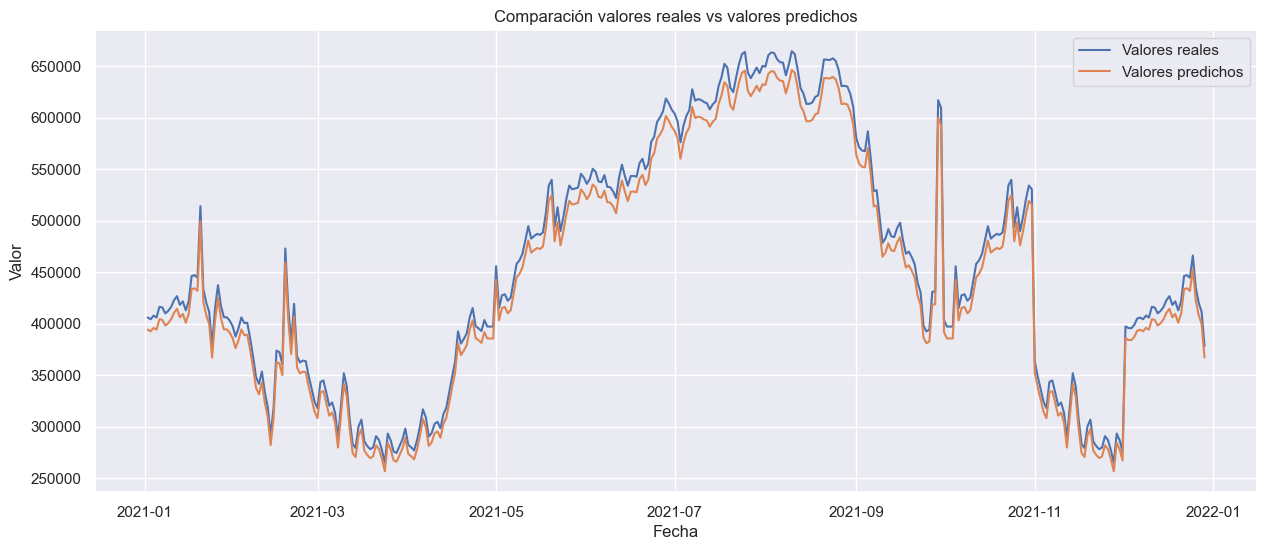

(<keras.src.engine.sequential.Sequential at 0x1ee0a982b90>,
 <keras.src.callbacks.History at 0x1eee9a22170>)

In [426]:
LSTMDemandaDiasSoloDemanda(datasetDemandaDias, 1, config2)

#### Look_back=7

Epoch 1/50
23/23 [==============================] - 9s 50ms/step - loss: 0.0421
Epoch 2/50
23/23 [==============================] - 1s 45ms/step - loss: 0.0075
Epoch 3/50
23/23 [==============================] - 1s 49ms/step - loss: 0.0054
Epoch 4/50
23/23 [==============================] - 1s 45ms/step - loss: 0.0046
Epoch 5/50
23/23 [==============================] - 1s 51ms/step - loss: 0.0034
Epoch 6/50
23/23 [==============================] - 1s 53ms/step - loss: 0.0036
Epoch 7/50
23/23 [==============================] - 1s 32ms/step - loss: 0.0033
Epoch 8/50
23/23 [==============================] - 1s 41ms/step - loss: 0.0032
Epoch 9/50
23/23 [==============================] - 1s 42ms/step - loss: 0.0032
Epoch 10/50
23/23 [==============================] - 1s 41ms/step - loss: 0.0028
Epoch 11/50
23/23 [==============================] - 1s 39ms/step - loss: 0.0025
Epoch 12/50
23/23 [==============================] - 1s 43ms/step - loss: 0.0030
Epoch 13/50
23/23 [==================

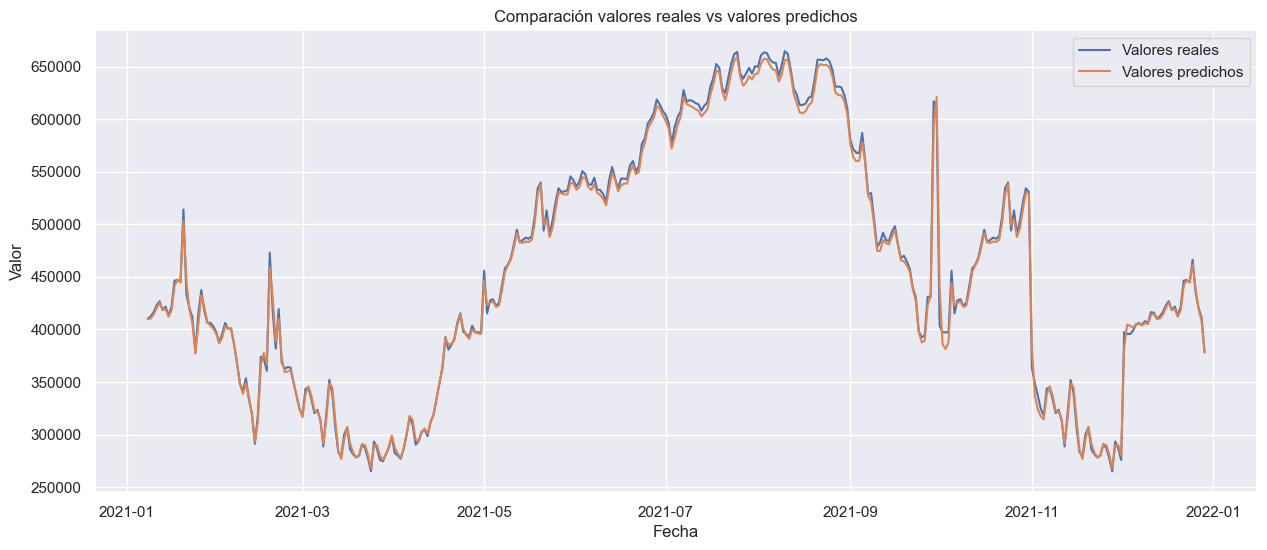

(<keras.src.engine.sequential.Sequential at 0x1eead4e9480>,
 <keras.src.callbacks.History at 0x1eee3cec1c0>)

In [424]:
LSTMDemandaDiasSoloDemanda(datasetDemandaDias, 7, config2)

#### Look_back=30

Epoch 1/50
22/22 [==============================] - 11s 156ms/step - loss: 0.0281
Epoch 2/50
22/22 [==============================] - 3s 136ms/step - loss: 0.0062
Epoch 3/50
22/22 [==============================] - 4s 171ms/step - loss: 0.0046
Epoch 4/50
22/22 [==============================] - 3s 144ms/step - loss: 0.0039
Epoch 5/50
22/22 [==============================] - 3s 137ms/step - loss: 0.0035
Epoch 6/50
22/22 [==============================] - 3s 155ms/step - loss: 0.0034
Epoch 7/50
22/22 [==============================] - 3s 132ms/step - loss: 0.0030
Epoch 8/50
22/22 [==============================] - 3s 118ms/step - loss: 0.0033
Epoch 9/50
22/22 [==============================] - 3s 125ms/step - loss: 0.0028
Epoch 10/50
22/22 [==============================] - 3s 125ms/step - loss: 0.0032
Epoch 11/50
22/22 [==============================] - 3s 124ms/step - loss: 0.0033
Epoch 12/50
22/22 [==============================] - 3s 129ms/step - loss: 0.0026
Epoch 13/50
22/22 [=====

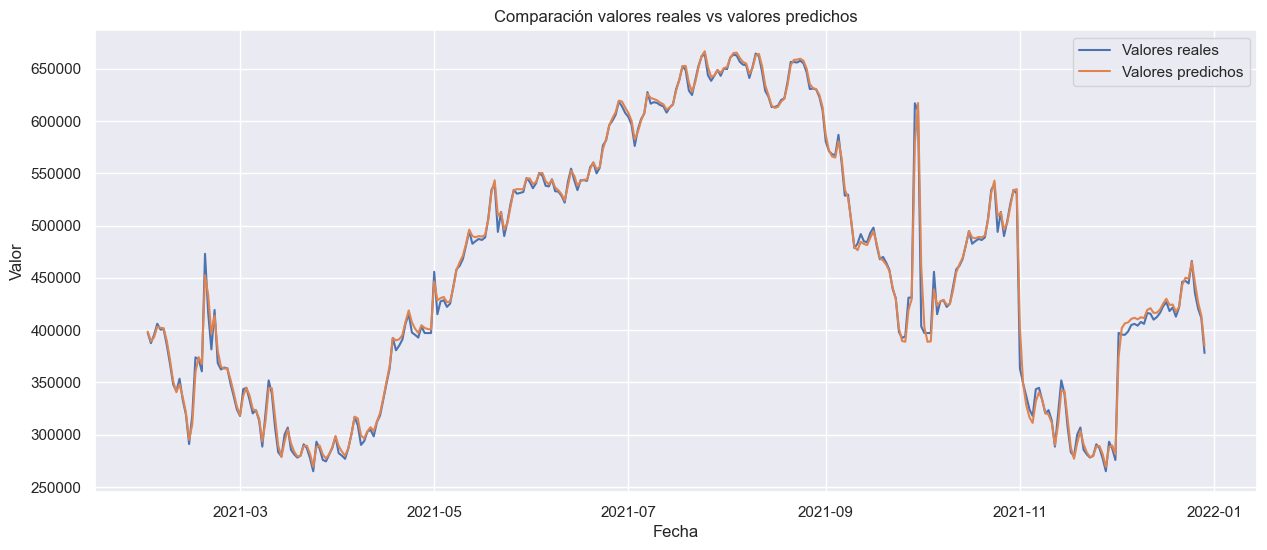

(<keras.src.engine.sequential.Sequential at 0x1eee3cbe4a0>,
 <keras.src.callbacks.History at 0x1eee68b0490>)

In [425]:
LSTMDemandaDiasSoloDemanda(datasetDemandaDias, 30, config2)

## De aqui abajo hasta el siguiente punto es lo antiguo, no borrar hasta que no se hagan bien todas las pruebas

In [301]:
dataRNNdiasDemanda = pd.read_csv("datosFinales.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataRNNdiasDemanda), freq='D')
dataRNNdiasDemanda.index = date_index

In [302]:
dataRNNdiasDemanda.to_csv('datosFinales.csv', index=True)

Epoch 1/50
22/22 [==============================] - 6s 28ms/step - loss: 0.0439
Epoch 2/50
22/22 [==============================] - 1s 28ms/step - loss: 0.0088
Epoch 3/50
22/22 [==============================] - 1s 28ms/step - loss: 0.0060
Epoch 4/50
22/22 [==============================] - 1s 25ms/step - loss: 0.0049
Epoch 5/50
22/22 [==============================] - 1s 26ms/step - loss: 0.0039
Epoch 6/50
22/22 [==============================] - 1s 26ms/step - loss: 0.0030
Epoch 7/50
22/22 [==============================] - 1s 26ms/step - loss: 0.0027
Epoch 8/50
22/22 [==============================] - 1s 27ms/step - loss: 0.0027
Epoch 9/50
22/22 [==============================] - 1s 27ms/step - loss: 0.0027
Epoch 10/50
22/22 [==============================] - 1s 26ms/step - loss: 0.0027
Epoch 11/50
22/22 [==============================] - 1s 25ms/step - loss: 0.0028
Epoch 12/50
22/22 [==============================] - 1s 25ms/step - loss: 0.0027
Epoch 13/50
22/22 [==================

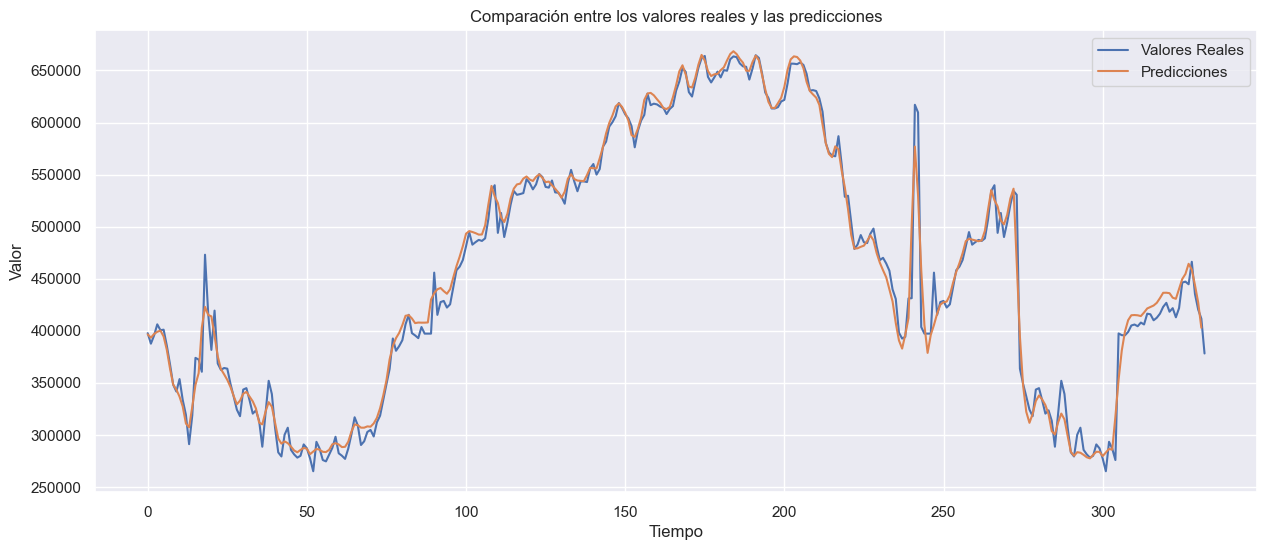

In [354]:
file_path = 'demanda_data.csv'
df = pd.read_csv(file_path)
start_date = datetime(2019, 1, 1)
end_date = datetime(2021, 12, 31)
delta = timedelta(days=1)
dates = []
current_date = start_date
while current_date <= end_date:
    dates.append(current_date)
    current_date += delta

dates = dates[:-1]
df['Date'] = dates
df = df[['Date', df.columns[0]]]
train_data = df[df['Date'] < '2021-01-01']
test_data = df[df['Date'] >= '2021-01-01']

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data.iloc[:, 1].values.reshape(-1, 1))
test_scaled = scaler.transform(test_data.iloc[:, 1].values.reshape(-1, 1))

look_back = 7
X_train, y_train, X_test, y_test = [], [], [], []
for i in range(look_back, len(train_scaled)):
    X_train.append(train_scaled[i-look_back:i, 0])
    y_train.append(train_scaled[i, 0])

for i in range(look_back, len(test_scaled)):
    X_test.append(test_scaled[i-look_back:i, 0])
    y_test.append(test_scaled[i, 0])


X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)


X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))


model.compile(optimizer='adam', loss='mean_squared_error')


history = model.fit(X_train, y_train, epochs=50, batch_size=32)

predicted_values = model.predict(X_test)
predicted_values = predicted_values[1:]



predicted_values = scaler.inverse_transform(np.reshape(predicted_values, (-1, 1)))
real_values = scaler.inverse_transform(y_test.reshape(-1, 1))

if len(predicted_values) != len(real_values):
    min_len = min(len(predicted_values), len(real_values))
    predicted_values = predicted_values[:min_len]
    real_values = real_values[:min_len]
mae = mean_absolute_error(real_values, predicted_values)
print(f"Mean Absolute Error (MAE): {mae}")


mse = mean_squared_error(real_values, predicted_values)
print(f"Mean Squared Error (MSE): {mse}")


threshold = 0.05
correct_predictions = np.abs(predicted_values - real_values) <= threshold * real_values
accuracy = np.mean(correct_predictions)
print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

plt.figure(figsize=(15, 6))
plt.plot(real_values, label='Valores Reales')  
plt.plot(predicted_values[1:], label='Predicciones')
plt.title('Comparación entre los valores reales y las predicciones')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.legend()
plt.show()



#buena buena


Epoch 1/50
23/23 [==============================] - 7s 12ms/step - loss: 0.0865
Epoch 2/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0092
Epoch 3/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0041
Epoch 4/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0033
Epoch 5/50
23/23 [==============================] - 0s 15ms/step - loss: 0.0033
Epoch 6/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0032
Epoch 7/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0032
Epoch 8/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0032
Epoch 9/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0032
Epoch 10/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0032
Epoch 11/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0032
Epoch 12/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0032
Epoch 13/50
23/23 [==================

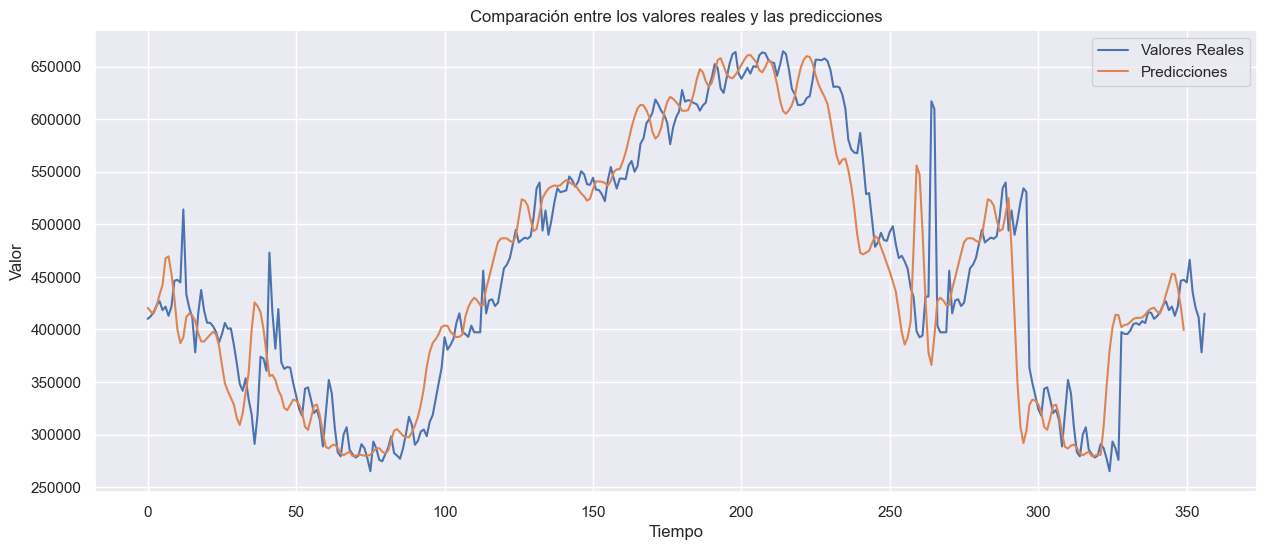

In [350]:
file_path = 'demanda_data.csv'
df = pd.read_csv(file_path)
start_date = datetime(2019, 1, 1)
end_date = datetime(2021, 12, 31)
delta = timedelta(days=1)
dates = []
current_date = start_date
while current_date <= end_date:
    dates.append(current_date)
    current_date += delta
dates = dates[:-1]
df['Date'] = dates
df = df[['Date', df.columns[0]]]

train_data = df[df['Date'] < '2021-01-01']
test_data = df[df['Date'] >= '2021-01-01']
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data.iloc[:, 1].values.reshape(-1, 1))
test_scaled = scaler.transform(test_data.iloc[:, 1].values.reshape(-1, 1))

X_train, y_train, X_test, y_test = [], [], [], []
look_back=1
for i in range(7, len(train_scaled)):
    X_train.append(train_scaled[i-7:i, 0])
    y_train.append(train_scaled[i, 0])

for i in range(7, len(test_scaled)):
    X_test.append(test_scaled[i-7:i, 0])
    y_test.append(test_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=50, batch_size=32)
predicted_values = model.predict(X_test)

predicted_values = scaler.inverse_transform(np.reshape(predicted_values, (-1, 1)))
predicted_values_aligned = predicted_values[7:]
real_values = scaler.inverse_transform(y_test.reshape(-1, 1))

mae = mean_absolute_error(real_values, predicted_values)
print(f"Resultado MAE: {mae}")
mse = mean_squared_error(real_values, predicted_values)
print(f"Resultado MSE: {mse}")
threshold = 0.05
correct_predictions = np.abs(predicted_values - real_values) <= threshold * real_values
accuracy = np.mean(correct_predictions)
print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

plt.figure(figsize=(15, 6))
plt.plot(real_values, label='Valores Reales')
plt.plot(predicted_values_aligned, label='Predicciones')
plt.title('Comparación entre los valores reales y las predicciones')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.legend()
plt.show()



In [57]:
print("Número de filas en el DataFrame: ", len(dataRNNdiasDemanda))
print("Número de elementos en el índice de fechas: ", len(date_index))

Número de filas en el DataFrame:  1096
Número de elementos en el índice de fechas:  1096


El desplazamiento se debió probablemente a cómo se prepararon los datos para el entrenamiento y las predicciones. En el modelo LSTM, utilizamos el valor del día anterior para predecir el valor del día actual. Esto significa que cuando hacemos predicciones en el conjunto de datos de prueba, la primera predicción en realidad corresponde al segundo elemento del conjunto de datos de prueba, la segunda predicción al tercer elemento, y así sucesivamente.

Por lo tanto, cuando intentamos comparar las predicciones con los valores reales, hay un desplazamiento natural porque las predicciones están "un paso detrás" de los valores reales a los que intentan predecir. Añadir o eliminar elementos al principio o al final de las series puede ayudar a alinear las predicciones con los valores reales para una comparación más precisa.

In [358]:
from keras.layers import Dropout
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

def train_evaluate_lstm(dataset, look_back, config):
    # Preprocesamiento
    start_date = datetime(2019, 1, 1)
    end_date = datetime(2021, 12, 31)
    delta = timedelta(days=1)
    dates = []
    current_date = start_date
    while current_date <= end_date:
        dates.append(current_date)
        current_date += delta
    dates = dates[:-1]
    dataset['Date'] = dates
    dataset = dataset[['Date', dataset.columns[0]]]
    train_data = dataset[dataset['Date'] < '2021-01-01']
    test_data = dataset[dataset['Date'] >= '2021-01-01']

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data.iloc[:, 1].values.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.iloc[:, 1].values.reshape(-1, 1))

    X_train, y_train, X_test, y_test = [], [], [], []
    for i in range(look_back, len(train_scaled)):
        X_train.append(train_scaled[i-look_back:i, 0])
        y_train.append(train_scaled[i, 0])
    for i in range(look_back, len(test_scaled)):
        X_test.append(test_scaled[i-look_back:i, 0])
        y_test.append(test_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Crear modelo
    model = Sequential()
    for i in range(config['layers']):
        return_seq = True if i < config['layers'] - 1 else config['return_sequence']
        model.add(LSTM(units=config['units'], return_sequences=return_seq, recurrent_dropout=config['recurrent_dropout']))
    for units in config['dense_layers']:
        model.add(Dense(units=units))
        model.add(Dropout(config['dense_dropout']))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=50, batch_size=32)

    # Predicción y evaluación
    predicted_values = model.predict(X_test)
    if not config['return_sequence']:
        predicted_values = predicted_values[1:]
    predicted_values = scaler.inverse_transform(np.reshape(predicted_values, (-1, 1)))
    real_values = scaler.inverse_transform(y_test.reshape(-1, 1))
    if len(predicted_values) != len(real_values):
        min_len = min(len(predicted_values), len(real_values))
        predicted_values = predicted_values[:min_len]
        real_values = real_values[:min_len]
    
    mae = mean_absolute_error(real_values, predicted_values)
    mse = mean_squared_error(real_values, predicted_values)
    threshold = 0.05
    correct_predictions = np.abs(predicted_values - real_values) <= threshold * real_values
    accuracy = np.mean(correct_predictions)
    
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Accuracy based on a threshold of {threshold*100}%: {accuracy*100:.2f}%")
    
    plt.figure(figsize=(15, 6))
    plt.plot(real_values, label='Real Values')
    plt.plot(predicted_values, label='Predictions')
    plt.title('Real vs Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    return model, history




In [359]:
config6 = {
    'layers': 1,
    'units': 64,
    'return_sequence': False,
    'recurrent_dropout': 0,
    'dense_dropout': 0,
    'dense_layers': [32]
}

In [366]:
file_path = 'demanda_data.csv'
demandaFinal = pd.read_csv(file_path)

In [391]:
def parametrizaciones(dataset, look_back, config):
    start_date = datetime(2019, 1, 1)
    end_date = datetime(2021, 12, 31)
    delta = timedelta(days=1)
    dates = []
    current_date = start_date
    while current_date <= end_date:
        dates.append(current_date)
        current_date += delta
    dates = dates[:-1]
    dataset['Date'] = dates
    dataset = dataset[['Date', dataset.columns[0]]]
    train_data = dataset[dataset['Date'] < '2021-01-01']
    test_data = dataset[dataset['Date'] >= '2021-01-01']
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data.iloc[:, 1].values.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.iloc[:, 1].values.reshape(-1, 1))

    X_train, y_train, X_test, y_test = [], [], [], []
    for i in range(look_back, len(train_scaled)):
        X_train.append(train_scaled[i-look_back:i, 0])
        y_train.append(train_scaled[i, 0])
    for i in range(look_back, len(test_scaled)):
        X_test.append(test_scaled[i-look_back:i, 0])
        y_test.append(test_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # aquí es donde le paso los diferentes parametros
    model = Sequential()
    for i in range(config['layers']):
        return_seq = True if i < config['layers'] - 1 else config['return_sequence']
        model.add(LSTM(units=config['units'], return_sequences=return_seq, recurrent_dropout=config['recurrent_dropout']))
    for units in config['dense_layers']:
        model.add(Dense(units=units))
        model.add(Dropout(config['dense_dropout']))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=50, batch_size=32)
    predicted_values = model.predict(X_test)
    if not config['return_sequence']:
        predicted_values = predicted_values[1:]
    predicted_values = scaler.inverse_transform(np.reshape(predicted_values, (-1, 1)))
    real_values = scaler.inverse_transform(y_test.reshape(-1, 1))
    if len(predicted_values) != len(real_values):
        min_len = min(len(predicted_values), len(real_values))
        predicted_values = predicted_values[:min_len]
        real_values = real_values[:min_len]
    #metricas tipicas
    mae = mean_absolute_error(real_values, predicted_values)
    mse = mean_squared_error(real_values, predicted_values)
    #metrica propia
    threshold = 0.05
    correct_predictions = np.abs(predicted_values - real_values) <= threshold * real_values
    accuracy = np.mean(correct_predictions)
    
    print(f"Resultado del MAE: {mae}")
    print(f"Resultado del MSE: {mse}")
    print(f"Precisión según el umbral de {threshold*100}%: {accuracy*100:.2f}%")
    
    test_dates = test_data['Date'].tolist()[look_back:]

    # Si las longitudes no coinciden, recorta las listas
    min_len = min(len(test_dates), len(real_values))
    test_dates = test_dates[:min_len]
    real_values = real_values[:min_len]
    predicted_values = predicted_values[:min_len]

    # Convierte las fechas a números para que matplotlib las pueda entender
    test_dates = date2num(test_dates)

    # ... (tu código para entrenar el modelo y hacer predicciones)

    plt.figure(figsize=(15, 6))
    plt.plot(test_dates, real_values.flatten(), linestyle='-', label='Valores Reales')
    plt.plot(test_dates, predicted_values.flatten(), linestyle='-', label='Predicciones')
    plt.title('Comparación entre los valores reales y las predicciones')
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))  # intervalo de 50 días para los ticks
    plt.xlim([datetime(2021, 1, 1), datetime(2021, 12, 31)])
    plt.gcf().autofmt_xdate()  # autoformato para las fechas en el eje x para que sean más legibles

    plt.show()


    return model, history



Epoch 1/50


23/23 [==============================] - 4s 8ms/step - loss: 0.0345
Epoch 2/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0048
Epoch 3/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0023
Epoch 4/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0021
Epoch 5/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 6/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 7/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 8/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 9/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 10/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 11/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 12/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 13/50
23/23 [==============================] - 0s 6ms/

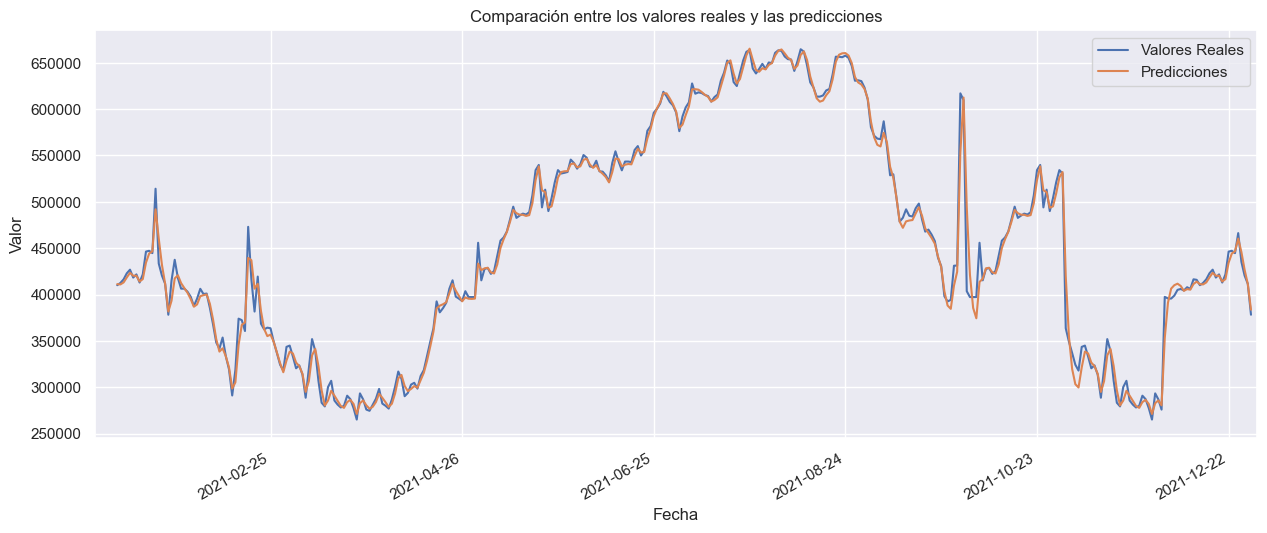

In [392]:

model, history = parametrizaciones(demandaFinal, 7, config6)

## LSTM por horas para predecir la demanda solo con la demanda

In [427]:
dataHoraDemanda = pd.read_csv("datosHorarios.csv")
dataHoraDemanda

,Produccion,Hours,Demanda
0,10494,1,11479
1,9914,2,10595
2,9452,3,10132
3,9334,4,10437
4,9832,5,11576
...,...,...,...
26347,12754,20,19725
26348,12639,21,18376
26349,12320,22,17323
26350,11802,23,16220


In [ ]:
date_hour_index = pd.date_range(start="01-01-2019", periods=len(dataHoraDemanda), freq='H')
dataHoraDemanda.index = date_hour_index
demand = dataHoraDemanda[['Demanda']]
train_data = demand.loc['2019-01-01':'2020-12-31 23:00:00']
val_data = demand.loc['2021-01-01':'2021-12-31 23:00:00']
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)

look_back = 24
def prepare_data(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

X_train, y_train = prepare_data(train_scaled, look_back)
X_val, y_val = prepare_data(val_scaled, look_back)

model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)

predictions = model.predict(X_val)
predictions = scaler.inverse_transform(predictions)
plt.figure(figsize=(15, 6))
plt.plot(val_data.index[look_back:], val_data['Demanda'].iloc[look_back:].values, label="Valores reales", color='blue')
plt.plot(val_data.index[look_back:], predictions, label="Predicciones", color='red', linestyle='dashed')
plt.title("Predicciones vs Valores reales (2021)")
plt.xlabel("Fecha y Hora")
plt.ylabel("Demanda")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
comparison = pd.DataFrame({'Real Values': val_data['Demanda'].iloc[look_back:].values, 'Predictions': predictions.flatten()})
print(comparison)

threshold = 0.01  # Se han hecho varias pruebas y se coge finalmente el 1% del valor real
correct_predictions = np.abs(predictions.flatten() - val_data['Demanda'].iloc[look_back:].values) <= threshold * val_data['Demanda'].iloc[look_back:].values
accuracy = np.mean(correct_predictions)
print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

## LSTM para predecir la demanda con todas las caracteristicas diaria

In [ ]:
dataFullCaracteristicas = pd.read_csv("datosFinales.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataFullCaracteristicas), freq='D')
dataFullCaracteristicas.index = date_index

In [ ]:
def LSTMDemandaDiaria2(time_steps, data):
    def assign_season(month):
        season_mapping = {
            1: 'Invierno', 2: 'Invierno', 3: 'Invierno',
            4: 'Primavera', 5: 'Primavera',
            6: 'Verano', 7: 'Verano', 8: 'Verano', 9: 'Verano',
            10: 'Otoño', 11: 'Otoño',
            12: 'Invierno'
        }
        return season_mapping[month]
    
    data['Estacion'] = data.index.month.map(assign_season)

    data = pd.get_dummies(data, columns=['Estacion'])

    ramadan_dates = [
        pd.date_range(start="06-may-2019", end="04-jun-2019", freq='D'),
        pd.date_range(start="24-apr-2020", end="23-may-2020", freq='D'),
        pd.date_range(start="13-apr-2021", end="12-may-2021", freq='D')
    ]
    shaaban_dates = [
        pd.date_range(start="06-apr-2019", end="05-may-2019", freq='D'),
        pd.date_range(start="25-mar-2020", end="23-apr-2020", freq='D'),
        pd.date_range(start="14-mar-2021", end="12-apr-2021", freq='D')
    ]

    data['Ramadan'] = data.index.isin(np.concatenate(ramadan_dates)).astype(int)
    data['Shaaban'] = data.index.isin(np.concatenate(shaaban_dates)).astype(int)

    festivos = ["2019-01-01", "2019-01-06", "2019-05-01", "2019-07-14", "2019-10-03",
                "2020-01-01", "2020-01-06", "2020-05-01", "2020-07-14", "2020-10-03",
                "2021-01-01", "2021-01-06", "2021-05-01", "2021-07-14", "2021-10-03"]
    data['Festivo'] = data.index.isin(festivos).astype(int)

    input_columns = ['Demanda', 'Produccion', 'Estacion_Invierno', 'Estacion_Otoño', 
                     'Estacion_Primavera', 'Estacion_Verano', 'Ramadan', 'Shaaban', 'Festivo']
    inputs = data[input_columns]
    target = data[['Demanda']]
    
    train_inputs = inputs.loc['2019-01-01':'2020-12-31']
    train_target = target.loc['2019-01-01':'2020-12-31']
    val_inputs = inputs.loc['2021-01-01':]
    val_target = target.loc['2021-01-01':]

    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Días")
    plt.ylabel("Demanda")
    plt.legend()
    plt.grid(True)
    plt.show()



    Cogiendo un día anterior para la prediccion

In [ ]:
LSTMDemandaDiaria2(1, dataFullCaracteristicas)

    Cogiendo 7 dias anterior para la prediccion

In [ ]:
LSTMDemandaDiaria2(7, dataFullCaracteristicas)

    Cogiendo 30 días anterior para la prediccion

In [ ]:
LSTMDemandaDiaria2(30, dataFullCaracteristicas)

    Cogiendo 60 dias anterior para la prediccion

In [ ]:
LSTMDemandaDiaria2(60, dataFullCaracteristicas)

## LSTM para predecir la demanda con todas las caracteristicas por horas

In [ ]:
dataHoras= pd.read_csv("datosHorarios.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataHoras), freq='D')
dataHoras.index = date_index

In [ ]:
dataHoras

In [ ]:


def LSTMDemandaHoraria(time_steps, data):
    def assign_season(month):
        season_mapping = {
            1: 'Invierno', 2: 'Invierno', 3: 'Invierno',
            4: 'Primavera', 5: 'Primavera',
            6: 'Verano', 7: 'Verano', 8: 'Verano', 9: 'Verano',
            10: 'Otoño', 11: 'Otoño',
            12: 'Invierno'
        }
        return season_mapping[month]
    
    data['Estacion'] = data.index.month.map(assign_season)

    data = pd.get_dummies(data, columns=['Estacion'])
    
    estaciones = ['Estacion_Invierno', 'Estacion_Otoño', 'Estacion_Primavera', 'Estacion_Verano']
    for estacion in estaciones:
        if estacion not in data.columns:
            data[estacion] = 0

    ramadan_dates = [
        pd.date_range(start="06-may-2019", end="04-jun-2019", freq='H'),
        pd.date_range(start="24-apr-2020", end="23-may-2020", freq='H'),
        pd.date_range(start="13-apr-2021", end="12-may-2021", freq='H')
    ]
    shaaban_dates = [
        pd.date_range(start="06-apr-2019", end="05-may-2019", freq='H'),
        pd.date_range(start="25-mar-2020", end="23-apr-2020", freq='H'),
        pd.date_range(start="14-mar-2021", end="12-apr-2021", freq='H')
    ]

    data['Ramadan'] = data.index.isin(np.concatenate(ramadan_dates)).astype(int)
    data['Shaaban'] = data.index.isin(np.concatenate(shaaban_dates)).astype(int)

    festivos = pd.to_datetime(["2019-01-01", "2019-01-06", "2019-05-01", "2019-07-14", "2019-10-03",
                               "2020-01-01", "2020-01-06", "2020-05-01", "2020-07-14", "2020-10-03",
                               "2021-01-01", "2021-01-06", "2021-05-01", "2021-07-14", "2021-10-03"])
    festivos_hours = [pd.date_range(start=f, end=f + pd.Timedelta(days=1), freq='H') for f in festivos]
    
    data['Festivo'] = data.index.isin(np.concatenate(festivos_hours)).astype(int)

    input_columns = ['Demanda', 'Produccion', 'Estacion_Invierno', 'Estacion_Otoño', 
                     'Estacion_Primavera', 'Estacion_Verano', 'Ramadan', 'Shaaban', 'Festivo']
    inputs = data[input_columns]
    target = data[['Demanda']]
    
    train_inputs = inputs.loc['2019-01-01 01:00:00':'2020-12-31 23:00:00']
    train_target = target.loc['2019-01-01 01:00:00':'2020-12-31 23:00:00']
    val_inputs = inputs.loc['2021-01-01 01:00:00':]
    val_target = target.loc['2021-01-01 01:00:00':]

    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    history=model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    

    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Horas")
    plt.ylabel("Demanda")
    plt.legend()
    plt.grid(True)
    plt.show()

    Cogiendo la hora anterior para la prediccion

In [ ]:
LSTMDemandaHoraria(1,dataHoras)

    Cogiendo 7 horas anterior para la prediccion

In [ ]:
LSTMDemandaHoraria(7,dataHoras)

    Cogiendo 24 horas anterior para la prediccion

In [ ]:
LSTMDemandaHoraria(24,dataHoras)

## LSTM para predecir la demanda con todas las caracteristicas por meses

In [ ]:
dataMes= data.resample('m').sum()
dataMes

In [ ]:
def LSTMDemandaMensual(time_steps, data):
    def assign_season(month):
        season_mapping = {
            1: 'Invierno', 2: 'Invierno', 3: 'Invierno',
            4: 'Primavera', 5: 'Primavera',
            6: 'Verano', 7: 'Verano', 8: 'Verano', 9: 'Verano',
            10: 'Otoño', 11: 'Otoño',
            12: 'Invierno'
        }
        return season_mapping[month]
    data['Estacion'] = data.index.month.map(assign_season)

    data = pd.get_dummies(data, columns=['Estacion'])

    ramadan_months = ["2019-05", "2019-06", "2020-04", "2020-05", "2021-04", "2021-05"]
    shaaban_months = ["2019-04", "2019-05", "2020-03", "2020-04", "2021-03", "2021-04"]

    data['Ramadan'] = data.index.strftime('%Y-%m').isin(ramadan_months).astype(int)
    data['Shaaban'] = data.index.strftime('%Y-%m').isin(shaaban_months).astype(int)

    festivos = ["2019-01", "2019-05", "2019-07", "2019-10", "2020-01", "2020-05", "2020-07", "2020-10", "2021-01", "2021-05", "2021-07", "2021-10"]
    data['Festivo'] = data.index.strftime('%Y-%m').isin(festivos).astype(int)

    input_columns = ['Demanda', 'Produccion', 'Estacion_Invierno', 'Estacion_Otoño', 
                     'Estacion_Primavera', 'Estacion_Verano', 'Ramadan', 'Shaaban', 'Festivo']
    inputs = data[input_columns]
    target = data[['Demanda']]
    
    train_inputs = inputs.loc['2019-01':'2020-12']
    train_target = target.loc['2019-01':'2020-12']
    val_inputs = inputs.loc['2021-01':]
    val_target = target.loc['2021-01':]

    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    history=model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

 
    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
   
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)
    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")
    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Meses")
    plt.ylabel("Demanda")
    plt.legend()
    plt.grid(True)
    plt.show()

    Cogiendo el mes anterior para la prediccion

In [ ]:
LSTMDemandaMensual(1,dataMes)

    Cogiendo 6 meses anterior para la prediccion

In [ ]:
LSTMDemandaMensual(6,dataMes)

## LSTM para predecir la demanda de un mes en concreto en con todas las caracteristicas por días

In [ ]:
dataFullCaracteristicas = pd.read_csv("datosFinales.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataFullCaracteristicas), freq='D')
dataFullCaracteristicas.index = date_index


In [ ]:
def LSTMDemandaDiariaPorMeses(time_steps, data, month_to_predict):
    def assign_season(month):
        season_mapping = {
            1: 'Invierno', 2: 'Invierno', 3: 'Invierno',
            4: 'Primavera', 5: 'Primavera',
            6: 'Verano', 7: 'Verano', 8: 'Verano', 9: 'Verano',
            10: 'Otoño', 11: 'Otoño',
            12: 'Invierno'
        }
        return season_mapping[month]
    
    data['Estacion'] = data.index.month.map(assign_season)
    data = pd.get_dummies(data, columns=['Estacion'])

    ramadan_dates = [
        pd.date_range(start="06-may-2019", end="04-jun-2019", freq='D'),
        pd.date_range(start="24-apr-2020", end="23-may-2020", freq='D'),
        pd.date_range(start="13-apr-2021", end="12-may-2021", freq='D')
    ]
    shaaban_dates = [
        pd.date_range(start="06-apr-2019", end="05-may-2019", freq='D'),
        pd.date_range(start="25-mar-2020", end="23-apr-2020", freq='D'),
        pd.date_range(start="14-mar-2021", end="12-apr-2021", freq='D')
    ]

    data['Ramadan'] = data.index.isin(np.concatenate(ramadan_dates)).astype(int)
    data['Shaaban'] = data.index.isin(np.concatenate(shaaban_dates)).astype(int)

    festivos = ["2019-01-01", "2019-01-06", "2019-05-01", "2019-07-14", "2019-10-03",
                "2020-01-01", "2020-01-06", "2020-05-01", "2020-07-14", "2020-10-03",
                "2021-01-01", "2021-01-06", "2021-05-01", "2021-07-14", "2021-10-03"]
    data['Festivo'] = data.index.isin(festivos).astype(int)

    input_columns = ['Demanda', 'Produccion', 'Estacion_Invierno', 'Estacion_Otoño', 
                     'Estacion_Primavera', 'Estacion_Verano', 'Ramadan', 'Shaaban', 'Festivo']
    inputs = data[input_columns]
    target = data[['Demanda']]
    
    train_inputs = inputs[(inputs.index.month == month_to_predict) & (inputs.index.year != 2021)]
    train_target = target[(target.index.month == month_to_predict) & (target.index.year != 2021)]
    val_inputs = inputs[(inputs.index.month == month_to_predict) & (inputs.index.year == 2021)]
    val_target = target[(target.index.month == month_to_predict) & (target.index.year == 2021)]


    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    history=model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Días")
    plt.ylabel("Demanda")
    plt.legend()
    plt.grid(True)
    plt.show()
 

Enero

In [ ]:
LSTMDemandaDiariaPorMeses(1, dataFullCaracteristicas, 1)

Febrero

In [ ]:
LSTMDemandaDiariaPorMeses(1, dataFullCaracteristicas, 2)

Marzo

In [ ]:
LSTMDemandaDiariaPorMeses(1, dataFullCaracteristicas, 3)

Abril

In [ ]:
LSTMDemandaDiariaPorMeses(1, dataFullCaracteristicas, 4)

Mayo

In [ ]:
LSTMDemandaDiariaPorMeses(1, dataFullCaracteristicas,5)

Junio

In [ ]:
LSTMDemandaDiariaPorMeses(1, dataFullCaracteristicas, 6)

Julio

In [ ]:
LSTMDemandaDiariaPorMeses(1, dataFullCaracteristicas, 7)

Agosto

In [ ]:
LSTMDemandaDiariaPorMeses(1, dataFullCaracteristicas, 8)

Septiembre

In [ ]:
LSTMDemandaDiariaPorMeses(1, dataFullCaracteristicas, 9)

Octubre

In [ ]:
LSTMDemandaDiariaPorMeses(1, dataFullCaracteristicas, 10)

Noviembre

In [ ]:
LSTMDemandaDiariaPorMeses(1, dataFullCaracteristicas, 11)

Diciembre

In [ ]:
LSTMDemandaDiariaPorMeses(1, dataFullCaracteristicas, 12)

# LSTM para predecir la demanda de un mes en concreto con solo la demanda por días

In [ ]:
def LSTMDemandaDiariaPorMesesSoloDemanda(time_steps, data, month_to_predict):
    target = data[['Demanda']]
    
    train_inputs = target[(target.index.month == month_to_predict) & (target.index.year != 2021)]
    val_inputs = target[(target.index.month == month_to_predict) & (target.index.year == 2021)]
    val_target = val_inputs.copy() 

    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_inputs)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val), verbose=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Días")
    plt.ylabel("Demanda")
    plt.legend()
    plt.grid(True)
    plt.show()

Enero

In [ ]:
LSTMDemandaDiariaPorMesesSoloDemanda(1, dataFullCaracteristicas, 1)

Febrero

In [ ]:
LSTMDemandaDiariaPorMesesSoloDemanda(1, dataFullCaracteristicas, 2)

Marzo

In [ ]:
LSTMDemandaDiariaPorMesesSoloDemanda(1, dataFullCaracteristicas, 3)

Abril

In [ ]:
LSTMDemandaDiariaPorMesesSoloDemanda(1, dataFullCaracteristicas, 4)

Mayo

In [ ]:
LSTMDemandaDiariaPorMesesSoloDemanda(1, dataFullCaracteristicas, 5)

Junio

In [ ]:
LSTMDemandaDiariaPorMesesSoloDemanda(1, dataFullCaracteristicas, 6)

Julio

In [ ]:
LSTMDemandaDiariaPorMesesSoloDemanda(1, dataFullCaracteristicas, 7)

Agosto

In [ ]:
LSTMDemandaDiariaPorMesesSoloDemanda(1, dataFullCaracteristicas, 8)

Septiembre

In [ ]:
LSTMDemandaDiariaPorMesesSoloDemanda(1, dataFullCaracteristicas, 9)

Octubre

In [ ]:
LSTMDemandaDiariaPorMesesSoloDemanda(1, dataFullCaracteristicas, 10)

Noviembre

In [ ]:
LSTMDemandaDiariaPorMesesSoloDemanda(1, dataFullCaracteristicas, 11)

Diciembre

In [ ]:
LSTMDemandaDiariaPorMesesSoloDemanda(1, dataFullCaracteristicas, 12)

# LSTM para predecir la demanda de un mes en concreto con todas las caracteristicas por días según configuración

In [ ]:
dataFullCaracteristicas = pd.read_csv("datosFinales.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataFullCaracteristicas), freq='D')
dataFullCaracteristicas.index = date_index


In [ ]:
dataFullCaracteristicas

In [ ]:
def LSTMDemandaDiariaPorMesesConfig(time_steps, data, month_to_predict, config):

    def assign_season(month):
        season_mapping = {
            1: 'Invierno', 2: 'Invierno', 3: 'Invierno',
            4: 'Primavera', 5: 'Primavera',
            6: 'Verano', 7: 'Verano', 8: 'Verano', 9: 'Verano',
            10: 'Otoño', 11: 'Otoño',
            12: 'Invierno'
        }
        return season_mapping[month]
    
    data['Estacion'] = data.index.month.map(assign_season)
    data = pd.get_dummies(data, columns=['Estacion'])

    ramadan_dates = [
        pd.date_range(start="06-may-2019", end="04-jun-2019", freq='D'),
        pd.date_range(start="24-apr-2020", end="23-may-2020", freq='D'),
        pd.date_range(start="13-apr-2021", end="12-may-2021", freq='D')
    ]
    shaaban_dates = [
        pd.date_range(start="06-apr-2019", end="05-may-2019", freq='D'),
        pd.date_range(start="25-mar-2020", end="23-apr-2020", freq='D'),
        pd.date_range(start="14-mar-2021", end="12-apr-2021", freq='D')
    ]

    data['Ramadan'] = data.index.isin(np.concatenate(ramadan_dates)).astype(int)
    data['Shaaban'] = data.index.isin(np.concatenate(shaaban_dates)).astype(int)

    festivos = ["2019-01-01", "2019-01-06", "2019-05-01", "2019-07-14", "2019-10-03",
                "2020-01-01", "2020-01-06", "2020-05-01", "2020-07-14", "2020-10-03",
                "2021-01-01", "2021-01-06", "2021-05-01", "2021-07-14", "2021-10-03"]
    data['Festivo'] = data.index.isin(festivos).astype(int)

    input_columns = ['Demanda', 'Produccion', 'Estacion_Invierno', 'Estacion_Otoño', 
                     'Estacion_Primavera', 'Estacion_Verano', 'Ramadan', 'Shaaban', 'Festivo']
    inputs = data[input_columns]
    target = data[['Demanda']]
    
    train_inputs = inputs[(inputs.index.month == month_to_predict) & (inputs.index.year != 2021)]
    train_target = target[(target.index.month == month_to_predict) & (target.index.year != 2021)]
    val_inputs = inputs[(inputs.index.month == month_to_predict) & (inputs.index.year == 2021)]
    val_target = target[(target.index.month == month_to_predict) & (target.index.year == 2021)]


    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    # para meter las capas
    for i in range(config['layers']):
        return_seq = config['return_sequence'] if i < config['layers'] - 1 else False
        model.add(LSTM(config['units'], activation='relu', return_sequences=return_seq, 
                       recurrent_dropout=config['recurrent_dropout'], 
                       input_shape=(X_train.shape[1], X_train.shape[2])))
    #la dense
    for units in config['dense_layers']:
        model.add(Dense(units, activation='relu'))
        if config['dense_dropout'] > 0:
            model.add(Dense(units, activation='relu'))
    
    model.add(Dense(1))

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), verbose=1)

    
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Días")
    plt.ylabel("Demanda")
    plt.legend()
    plt.grid(True)
    plt.show()
    return history.history['val_loss'][-1]
 

In [ ]:
config1 = {
    'layers': 1,
    'units': 128,
    'return_sequence': False,
    'recurrent_dropout': 0,
    'dense_dropout': 0.2,
    'dense_layers': [32, 64, 128]
}


In [ ]:

LSTMDemandaDiariaPorMesesConfig(10, dataFullCaracteristicas, 1, config1)

Configuración base con más unidades en la capa LSTM:

In [ ]:

config2 = {
    'layers': 1,
    'units': 256,
    'return_sequence': False,
    'recurrent_dropout': 0,
    'dense_dropout': 0.2,
    'dense_layers': [64, 128]
}

In [ ]:
LSTMDemandaDiariaPorMesesConfig(10, dataFullCaracteristicas, 1, config2)

Configuración con múltiples capas LSTM

In [ ]:
config3 = {
    'layers': 2,
    'units': 128,
    'return_sequence': True,
    'recurrent_dropout': 0,
    'dense_dropout': 0.2,
    'dense_layers': [32, 64]
}

In [ ]:
LSTMDemandaDiariaPorMesesConfig(10, dataFullCaracteristicas, 1, config3)

Configuración con dropout:

In [ ]:
config4 = {
    'layers': 1,
    'units': 128,
    'return_sequence': False,
    'recurrent_dropout': 0.2,
    'dense_dropout': 0.3,
    'dense_layers': [64]
}

In [ ]:
LSTMDemandaDiariaPorMesesConfig(10, dataFullCaracteristicas, 1, config4)

Configuración con más capas denses

In [ ]:
config5 = {
    'layers': 1,
    'units': 128,
    'return_sequence': False,
    'recurrent_dropout': 0,
    'dense_dropout': 0.2,
    'dense_layers': [32, 64, 128, 64]
}

In [ ]:
LSTMDemandaDiariaPorMesesConfig(10, dataFullCaracteristicas, 1, config5)

Configuración simple para evitar sobre ajustes

In [ ]:
config6 = {
    'layers': 1,
    'units': 64,
    'return_sequence': False,
    'recurrent_dropout': 0,
    'dense_dropout': 0,
    'dense_layers': [32]
}

In [ ]:
LSTMDemandaDiariaPorMesesConfig(10, dataFullCaracteristicas, 1, config6)

# Compración para sacar la mejor configuración

In [ ]:
def train_and_validate_fixed_years_ranked_with_names(model, data, configs):
    train_data = data[data.index.year.isin([2019, 2020])]
    val_data = data[data.index.year == 2021]
    
    results = []
    for config_name, config in configs.items():
        #aqui le cambio el look_back y el mes
        result = model(1, train_data.append(val_data), 1, config)
        results.append((config_name, config, result))
    
    ranked_results = sorted(results, key=lambda x: x[2])
    return ranked_results

configs_dict = {
    'config1': config1,'config2': config2,'config3': config3,'config4': config4,'config5': config5,'config6': config6,


}
ranked_results = train_and_validate_fixed_years_ranked_with_names(LSTMDemandaDiariaPorMesesConfig, dataFullCaracteristicas, configs_dict)
ranked_results

# LSTM para predecir la demanda de 2022


### Primera parametrización

In [ ]:
dataRNNdiasDemanda = pd.read_csv("datosFinales.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataRNNdiasDemanda), freq='D')
dataRNNdiasDemanda.index = date_index
demand = dataRNNdiasDemanda[['Demanda']]

In [ ]:

demand = dataRNNdiasDemanda[['Demanda']]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(demand)

def prepare_data(data):
    X, y = [], []
    for i in range(len(data) - 1):
        X.append(data[i])
        y.append(data[i + 1])
    return np.array(X), np.array(y)

X, y = prepare_data(scaled_data)
X = np.reshape(X, (X.shape[0], 1, 1))

model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=False, recurrent_dropout=0.2, input_shape=(1, 1)))  
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=50, verbose=1)

predictions = []
last_value = scaled_data[-1]

for i in range(365):
    x_input = np.reshape(last_value, (1, 1, 1))
    next_value = model.predict(x_input)
    predictions.append(next_value)
    last_value = next_value

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

plt.plot(pd.date_range(start='2022-01-01', periods=365, freq='D'), predictions, label='Predicciones 2022')
plt.title('Predicciones de Demanda Energética para 2022')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.show()


### Con la segunda parametrización

In [ ]:
demand = dataRNNdiasDemanda[['Demanda']]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(demand)

def prepare_data(data):
    X, y = [], []
    for i in range(len(data) - 1):
        X.append(data[i])
        y.append(data[i + 1])
    return np.array(X), np.array(y)

X, y = prepare_data(scaled_data)
X = np.reshape(X, (X.shape[0], 1, 1))

model = Sequential()
model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(1, 1)))
model.add(LSTM(100, activation='tanh'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=100, verbose=1)

predictions = []
last_value = scaled_data[-1]

for i in range(365):
    x_input = np.reshape(last_value, (1, 1, 1))
    next_value = model.predict(x_input)
    predictions.append(next_value)
    last_value = next_value

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

plt.plot(pd.date_range(start='2022-01-01', periods=365, freq='D'), predictions, label='Predicciones 2022')
plt.title('Predicciones de Demanda Energética para 2022')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.show()


### Tercera parametrización

In [ ]:
config_model = {
    'layers': 3,
    'units': 150,  
    'return_sequence': [True, True, False],  
    'activation': 'tanh',  
    'recurrent_dropout': 0.2,  
    'dense_dropout': 0,  
    'dense_layers': [75, 1],  
    'learning_rate': 0.001, 
    'epochs': 200  
}

In [ ]:
demand = dataRNNdiasDemanda[['Demanda']]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(demand)

def prepare_data(data, look_back=30):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)
X, y = prepare_data(scaled_data)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(LSTM(150, activation='tanh', return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(150, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150, activation='tanh'))
model.add(Dense(75, activation='relu'))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

model.fit(X, y, epochs=200, verbose=1)

predictions = []
last_30_days = scaled_data[-30:]

for i in range(365):
    x_input = last_30_days.reshape((1, 30, 1))
    next_value = model.predict(x_input)
    predictions.append(next_value)
    
    last_30_days = np.roll(last_30_days, -1)
    last_30_days[-1] = next_value

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

plt.plot(pd.date_range(start='2022-01-01', periods=365, freq='D'), predictions, label='Predicciones 2022')
plt.title('Predicciones de Demanda Energética para 2022')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.show()
